In [1]:
import cv2
import pickle
import csv
from skimage import exposure

pip install opencv-python 

In [2]:
def preprocess_images(file_name, grayscale = False, equalize = None, normalize=False, contrast = False):
    path = 'C:/Users/vyasd/Downloads/Compressed/New folder/'   

    img_infos = {'labels':[],'images':[]}

    with open(path+file_name,"r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',', quotechar='|')
        next(reader)
        
        for row in reader:

            img = cv2.imread(path+row[-1], cv2.IMREAD_UNCHANGED) 
            
            if contrast and exposure.is_low_contrast(img, fraction_threshold=0.1, upper_percentile=90):
                img = exposure.adjust_gamma(img, 0.5)
            
            if normalize:
                cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Normalize
            else:
                img = (img-127.5)/127.5
            
            if equalize is not None:
                img = equalize(img)
                
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image to Grayscale
            
            img = cv2.resize(img, (32,32),interpolation = cv2.INTER_AREA) #Resize the image to 32x32
            
            img_infos['images'].append(img) #Save Image pixels
            img_infos['labels'].append(row[-2]) #Save image Label
            
            
    return img_infos

In [3]:
# Normalized Grayscale
test_gray = preprocess_images("Test.csv", grayscale=True, normalize=True)

with open("C:/Users/vyasd/Downloads/Compressed/New folder/PickledData/Test_normalize.p", 'wb') as pickle_rick:
    pickle.dump(test_gray,pickle_rick)    
print("> Finished writing tests")

train_gray = preprocess_images("Train.csv", grayscale=True, normalize=True)
with open("C:/Users/vyasd/Downloads/Compressed/New folder/PickledData/Train_normalize.p", 'wb') as pickle_rick:
    pickle.dump(train_gray,pickle_rick)
print("> Finished writing train")

> Finished writing tests
> Finished writing train


In [4]:
import random
import numpy as np
import pickle
import cv2
import time

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from skimage import transform, exposure

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def augment_img(img):
    img = transform.rotate(img, random.uniform(-45,45))
    img = exposure.adjust_gamma(img, random.uniform(0.5, 1.5))
    return img


def augment_set(x_set, y_set):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
        
    for i in range(len(y_set)):
        label_dic[str(y_set[i])].append(x_set[i])
    
    for i in label_dic:
        while len(label_dic[i]) < 1500:
            rand_index = random.randint(0, len(label_dic[i]) -1)
            label_dic[i].append(augment_img(label_dic[i][rand_index]))
    
    aug_x = []
    aug_y = []
    for label in label_dic:
        for img in label_dic[label]:
            aug_y.append(int(label))
            aug_x.append(img)
    return aug_x, aug_y

def augment_set_equal(x_set, y_set):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
        
    for i in range(len(y_set)):
        label_dic[str(y_set[i])].append(x_set[i])
    
    for i in label_dic:
        while len(label_dic[i]) < 5000:
            rand_index = random.randint(0, len(label_dic[i]) -1)
            label_dic[i].append(augment_img(label_dic[i][rand_index]))
    
    aug_x = []
    aug_y = []
    for label in label_dic:
        while len(aug_x) < (1500*int(label)+1500):
            rand_index = random.randint(0, len(label_dic[label]) -1)
            aug_y.append(int(label))
            aug_x.append(label_dic[label].pop(rand_index))
    return aug_x, aug_y

In [6]:
def create_cv_random(x_train, y_train):
    # Get the cross validation set
    x_cv = []
    y_cv = []
    for i in range(int(0.2*len(x_train))): # Randomly move 20% of the training examples into the cross-validation set
        index = random.randint(0, len(x_train)-1)
        x_cv.append(x_train.pop(index))
        y_cv.append(y_train.pop(index))
        
    return x_cv, y_cv

def create_cv_equitative(x_train, y_train):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
    
    for i in range(len(y_train)):
        label_dic[str(y_train[i])].append(x_train[i])
    
    x_cv = []
    y_cv = []
    for label in label_dic:
        for i in range(int(0.2*len(label_dic[label]))):
            index = random.randint(0, len(label_dic[label]) -1)
            y_cv.append(int(label))
            x_cv.append(label_dic[label].pop(index))
        
    x_train = []
    y_train = []
    for label in label_dic:
        for img in label_dic[label]:
            y_train.append(int(label))
            x_train.append(img)
    x_cv, y_cv = shuffle(x_cv, y_cv)
    return x_cv, y_cv, x_train, y_train

def open_set(path_test, path_train, gray = False, cv_random = True, augment=False):

    with open(path_test, "rb") as f:
        test = pickle.load(f)
    with open(path_train, "rb") as f:
        train = pickle.load(f)

    # Get the training set
    x_train, y_train = train['images'], train['labels']
    
    if augment:
        #Normalize images
        x_train, y_train= augment_set_equal(x_train, y_train)

        print("finished augmenting set")

    # Get the cross validation set
    if cv_random:
        x_cv, y_cv = create_cv_random(x_train, y_train)
    else:
        x_cv, y_cv, x_train, y_train = create_cv_equitative(x_train, y_train)

    # Get the test set
    x_test, y_test = test['images'], test['labels']

    # Convert all our sets into numPy Arrays
    if gray:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 1))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 1))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 1))
        y_test = keras.utils.to_categorical(np.array(y_test))
    else:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 3))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 3))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 3))
        y_test = keras.utils.to_categorical(np.array(y_test))
    
    
    
    return x_test, y_test, x_train, y_train, x_cv, y_cv

In [7]:
x_test, y_test, x_train, y_train, x_cv, y_cv = open_set("C:/Users/vyasd/Downloads/Compressed/New folder/PickledData/Test_normalize.p", "C:/Users/vyasd/Downloads/Compressed/New folder/PickledData/Train_normalize.p", gray=True, cv_random=False)

In [8]:
# Shuffle the training set
x_train, y_train = shuffle(x_train, y_train)

In [9]:

EPOCHS = 25
BATCH_SIZE = 200
LOSS = keras.losses.categorical_crossentropy
OPT = keras.optimizers.Adam
LEARNING_RATE = 0.002 # Define the learning rate to be used by our optimizer

In [10]:
def LeNetModel(no_output=6, rgb=True, drop_fully_connected=0, drop_convolutional=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
        
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    model.add(keras.layers.Dropout(drop_convolutional))
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    # Third Layer - Convolutional ; Input = 14x14x6 ; Output = 10x10x16
    model.add(keras.layers.Conv2D(
                    filters=16, kernel_size=(3, 3),
                    activation='relu'
                    )
                 )
    
    # Fourth Layer - Subsampling (Average Pooling) ; Input = 10x10x16 ; Output = 5x5x16
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))

    # Sixth Layer - Fully Connected ; Input = 120x1 ; Output = 84x1
    model.add(keras.layers.Dense(units=84, activation='relu'))
    
    model.add(keras.layers.Dropout(drop_fully_connected))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

In [11]:
def LeNetModel_1CL(no_output=6, rgb=True, dropout=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
    
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))

    # Sixth Layer - Fully Connected ; Input = 120x1 ; Output = 84x1
    model.add(keras.layers.Dense(units=84, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

In [12]:
def LeNetModel_1FL(no_output=6, rgb=True, dropout=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
    
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    # Third Layer - Convolutional ; Input = 14x14x6 ; Output = 10x10x16
    model.add(keras.layers.Conv2D(
                    filters=16, kernel_size=(3, 3),
                    activation='relu'
                    )
                 )
    
    # Fourth Layer - Subsampling (Average Pooling) ; Input = 10x10x16 ; Output = 5x5x16
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

In [13]:
model = LeNetModel(rgb=False)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])


In [14]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Epoch 1/25
157/157 [==============================] - 7s 43ms/step - loss: 3.4943 - accuracy: 0.3630 - val_loss: 1.2240 - val_accuracy: 0.6752
Epoch 2/25
157/157 [==============================] - 6s 40ms/step - loss: 0.8070 - accuracy: 0.7932 - val_loss: 0.5180 - val_accuracy: 0.8741
Epoch 3/25
157/157 [==============================] - 6s 40ms/step - loss: 0.4162 - accuracy: 0.8973 - val_loss: 0.4067 - val_accuracy: 0.8998
Epoch 4/25
157/157 [==============================] - 6s 41ms/step - loss: 0.2886 - accuracy: 0.9290 - val_loss: 0.3208 - val_accuracy: 0.9234
Epoch 5/25
157/157 [==============================] - 6s 40ms/step - loss: 0.2092 - accuracy: 0.9490 - val_loss: 0.2471 - val_accuracy: 0.9415
Epoch 6/25
157/157 [==============================] - 6s 41ms/step - loss: 0.1650 - accuracy: 0.9586 - val_loss: 0.2260 - val_accuracy: 0.9489
Epoch 7/25
157/157 [==============================] - 6s 41ms/step - loss: 0.1359 - accuracy: 0.9654 - val_loss: 0.1730 - val_accuracy: 0.9592

In [15]:
def create_confusion_matrices(y_test, y_predictions):
    #Absolute matrix (number of guesses)
    conf_mat_abs = confusion_matrix(np.argmax(y_test, axis=1), y_predictions)

    #Relative matrix (normalized number of guesses (0-1))
    conf_mat_rel = conf_mat_abs.astype('float') / conf_mat_abs.sum(axis=1)[:, np.newaxis]
    
    return conf_mat_abs, conf_mat_rel

In [16]:

def plot_confusion(conf_matrix, title):
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(43)],
                      columns = [i for i in range(43)])
    plt.figure(figsize = (22,22))
    
    ax = sn.heatmap(df_cm, annot=False)
    
    plt.ylabel('Actual Class', fontsize=15)
    plt.xlabel("Guessed Class", fontsize=15)
    
    ax.collections[0].colorbar.set_label("Probability of Guess (%)", fontsize=15)
    plt.title(title,fontsize=18)

    plt.show()

In [17]:
def plot_acc_per_class(conf_mat):
    plt.figure(figsize = (7.25,6))
    plt.bar(range(0,43), [conf_mat_rel[i][i] for i in range(43)], color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('Accuracy of guess (%)',fontsize=12)
    plt.title('Accuracy of model per class',fontsize=15)
    plt.show()

In [18]:
def plot_cv_per_class(y_cv, y_train):
    plt.figure(figsize = (20,7))
    
    plt.subplot(1,2,1)
    plt.hist(np.argmax(y_cv, axis=1), bins = range(0,44), color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the CV Set',fontsize=15)

    
    plt.subplot(1,2,2)
    plt.hist(np.argmax(y_train, axis=1), bins = range(0,44), color="#731f58")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the Train Set',fontsize=15)


    plt.show()

In [19]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


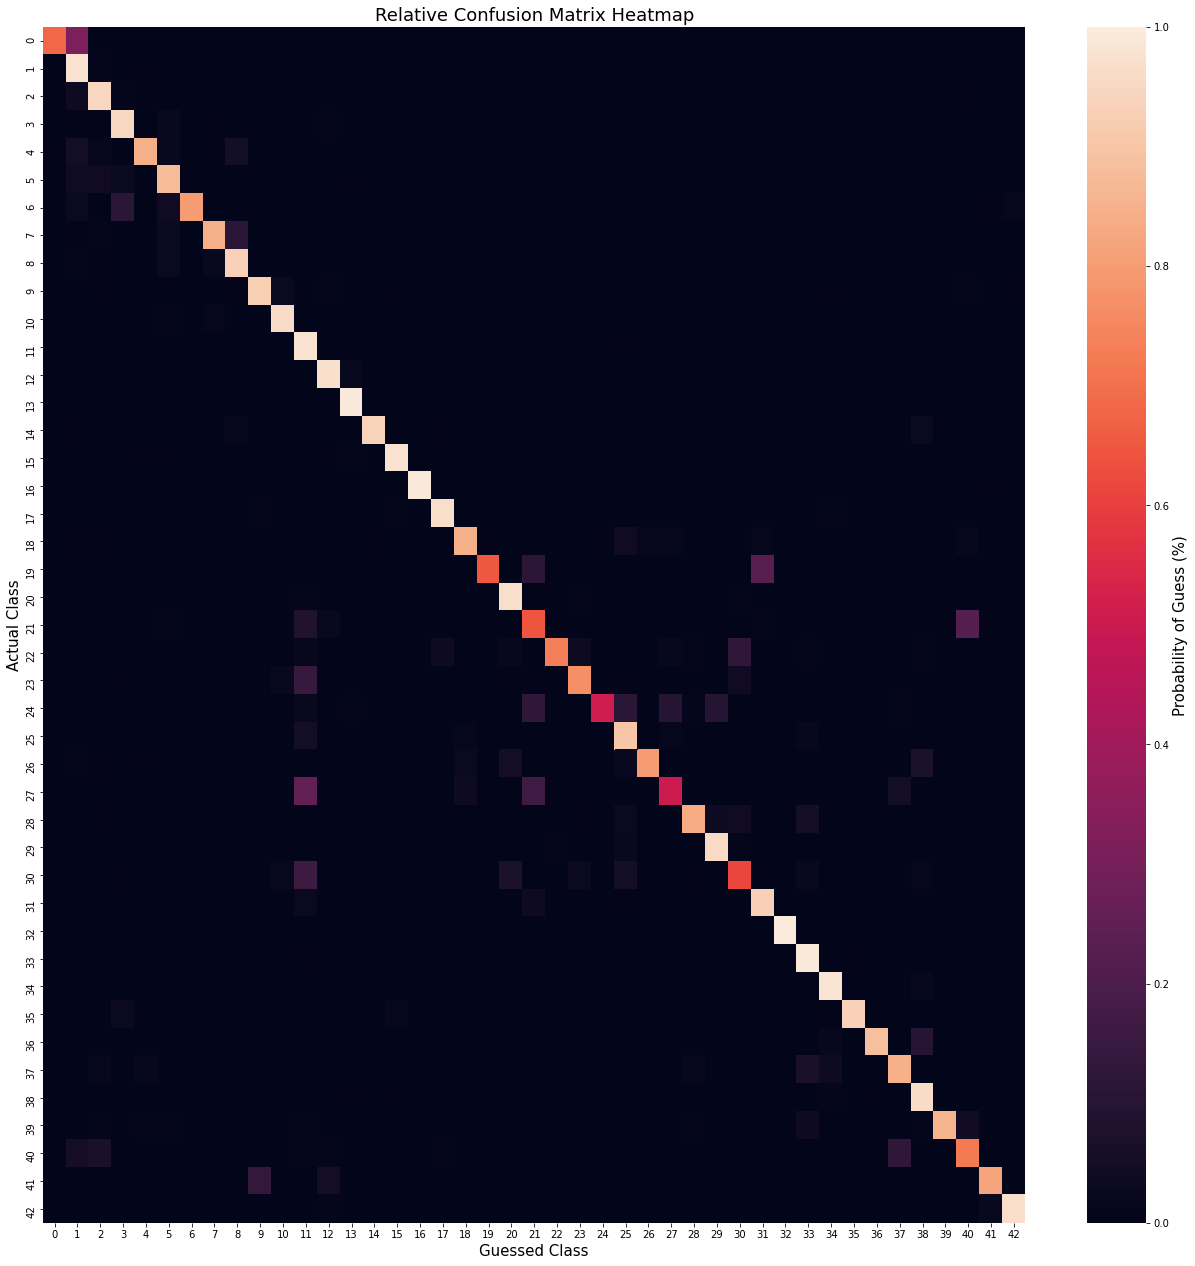

In [20]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")


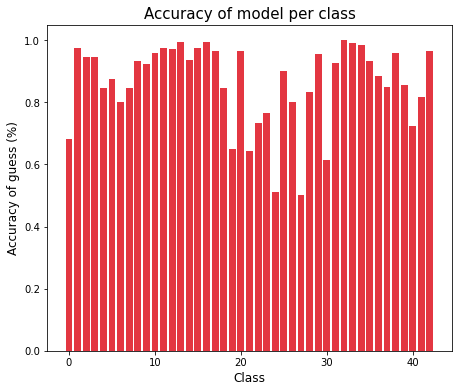

In [21]:
plot_acc_per_class(conf_mat_rel)

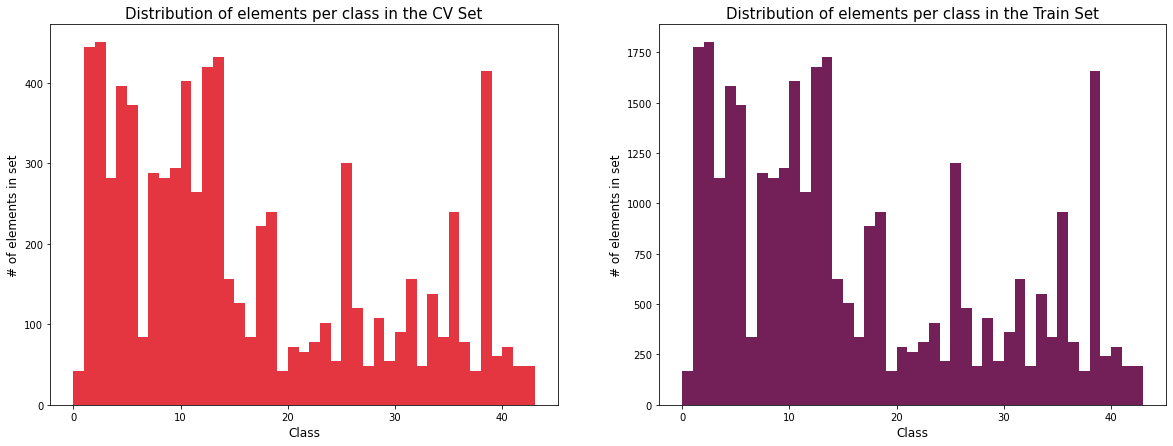

In [22]:
plot_cv_per_class(y_cv,y_train)

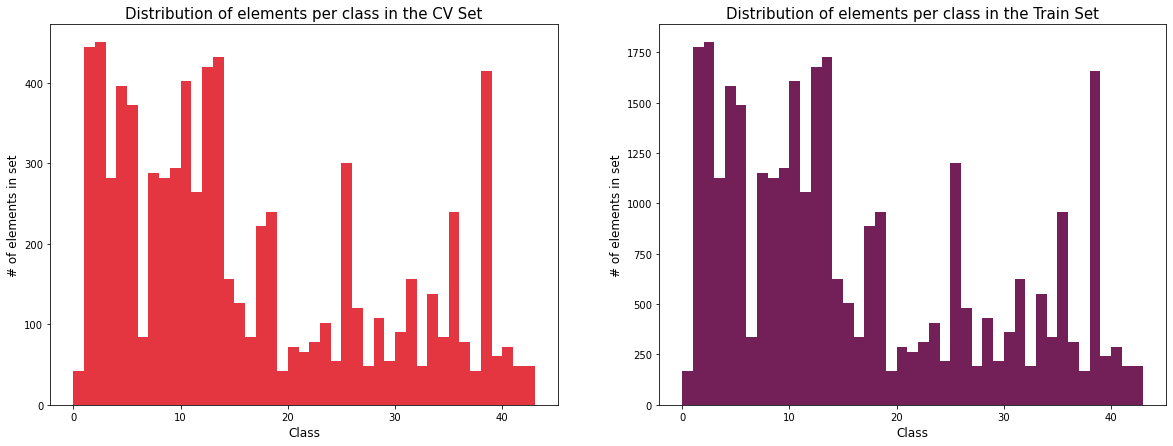

In [23]:

plot_cv_per_class(y_cv,y_train)

In [24]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


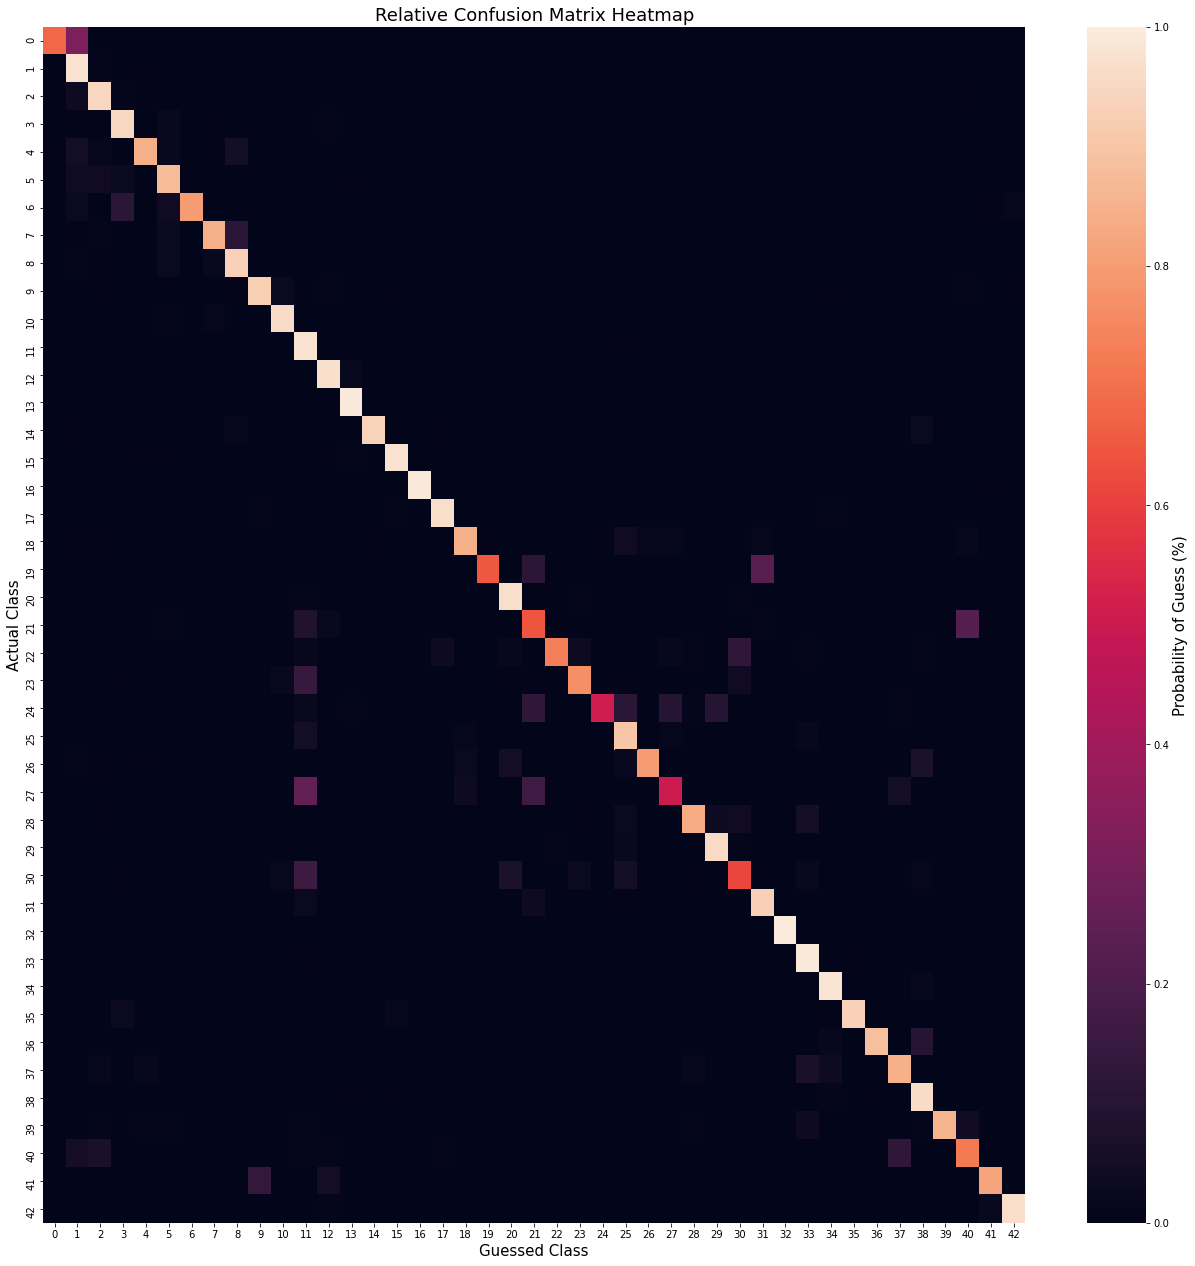

In [25]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

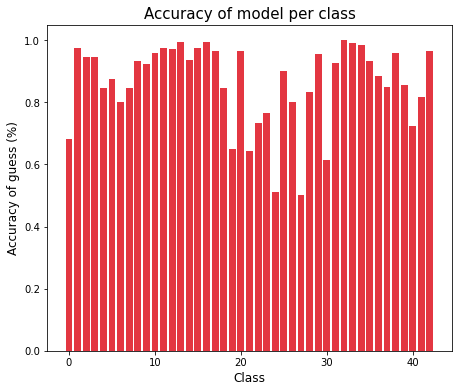

In [26]:
plot_acc_per_class(conf_mat_rel)

In [27]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


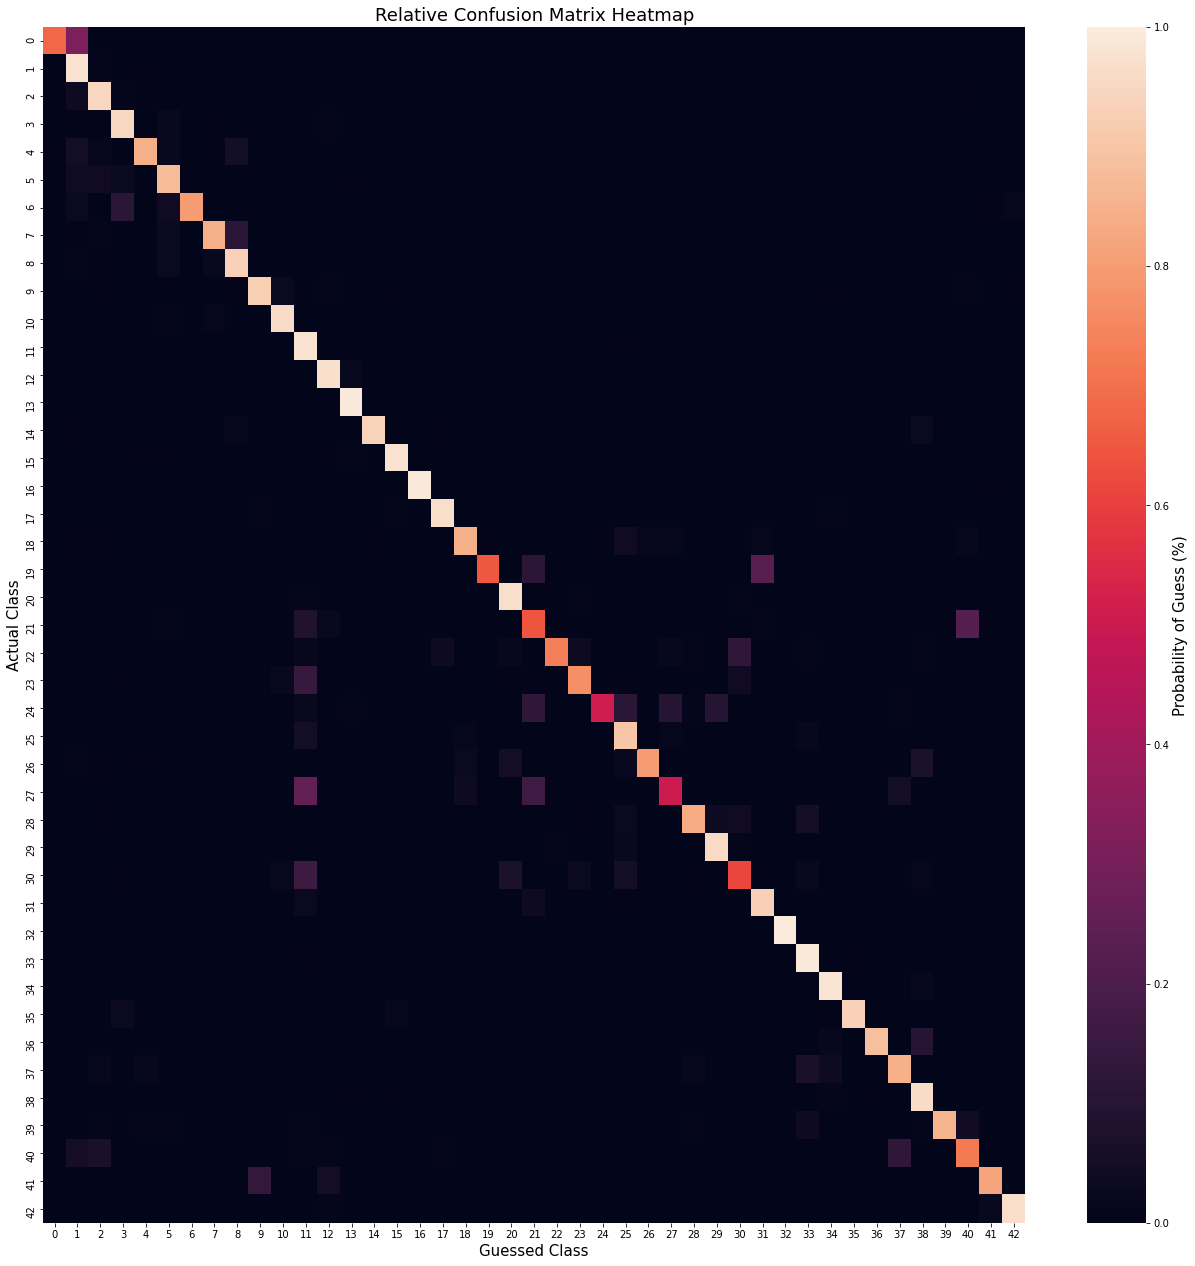

In [28]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")


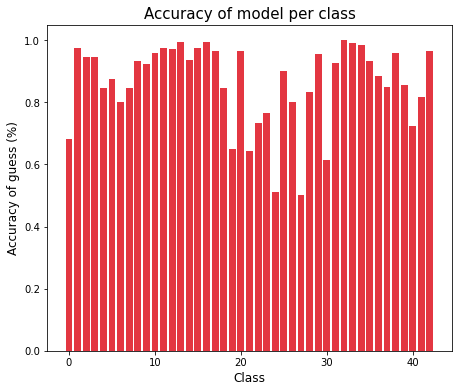

In [29]:
plot_acc_per_class(conf_mat_rel)

In [30]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


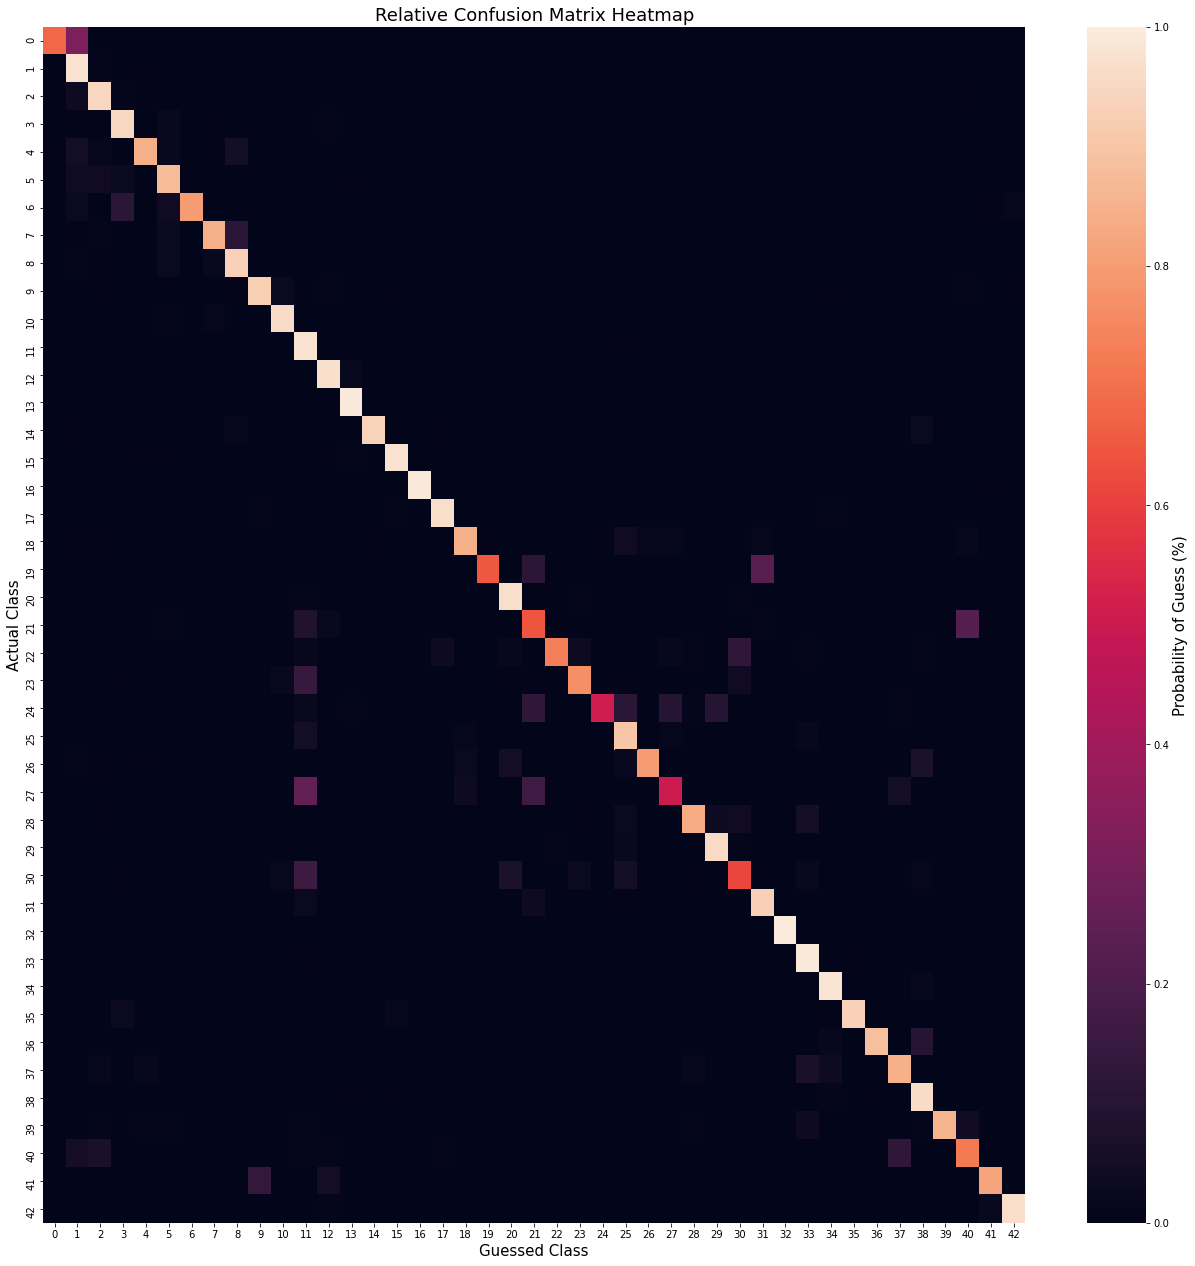

In [31]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

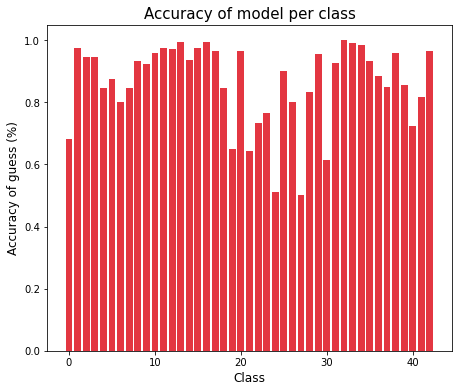

In [32]:
plot_acc_per_class(conf_mat_rel)

In [33]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])


395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


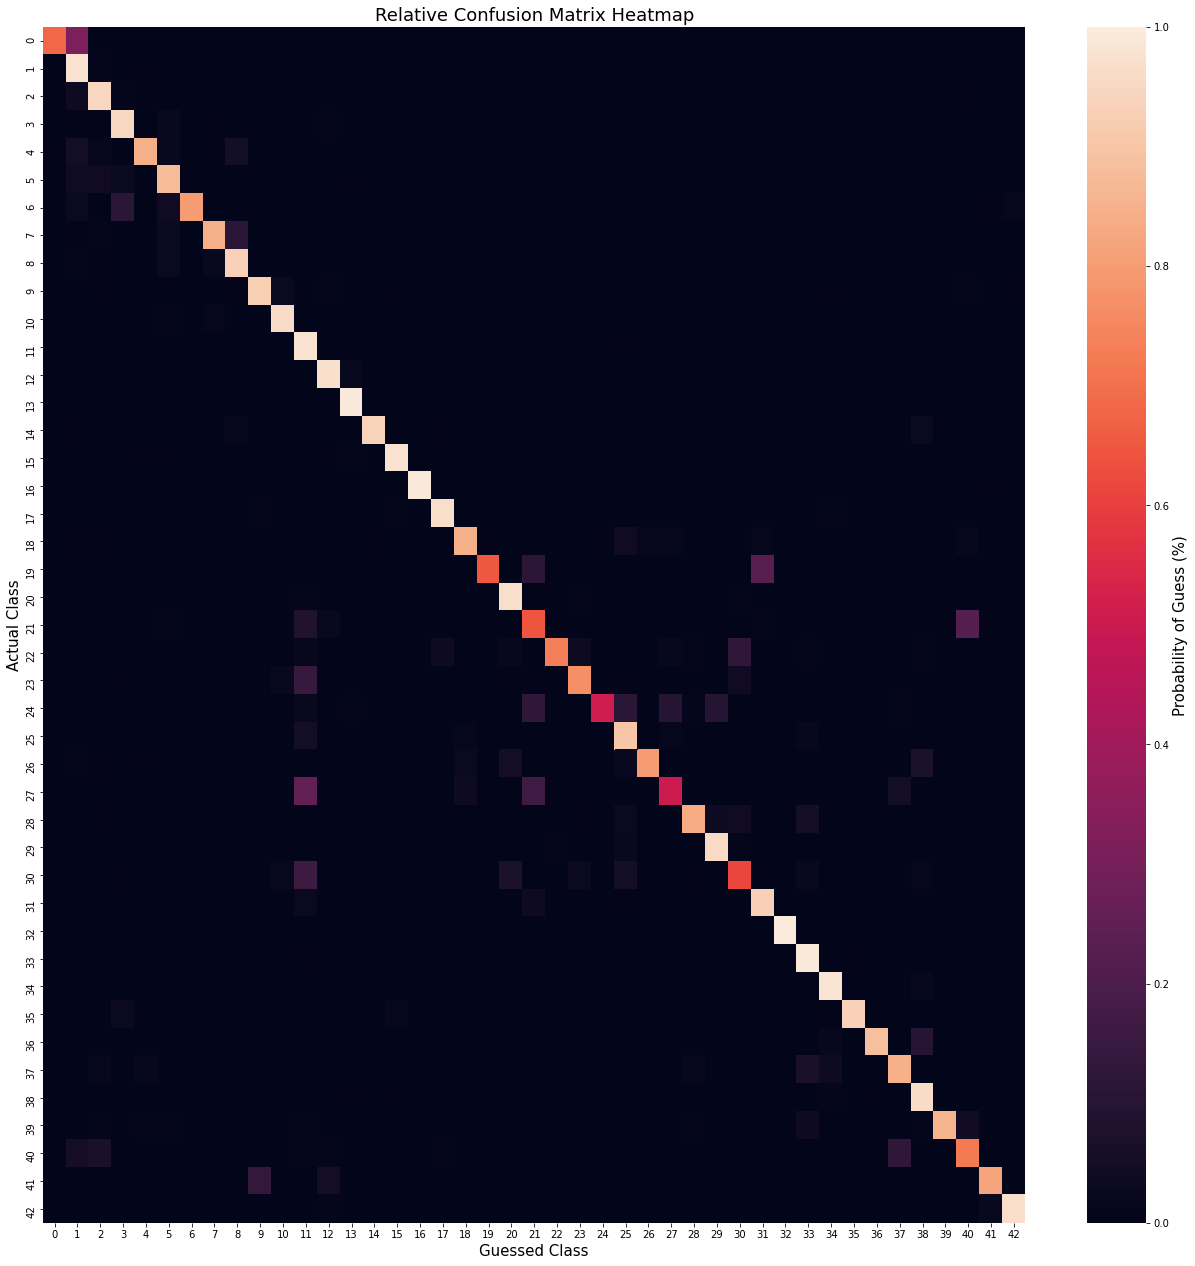

In [34]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

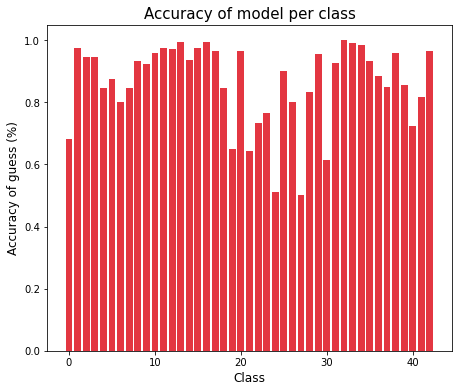

In [35]:
plot_acc_per_class(conf_mat_rel)

In [36]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


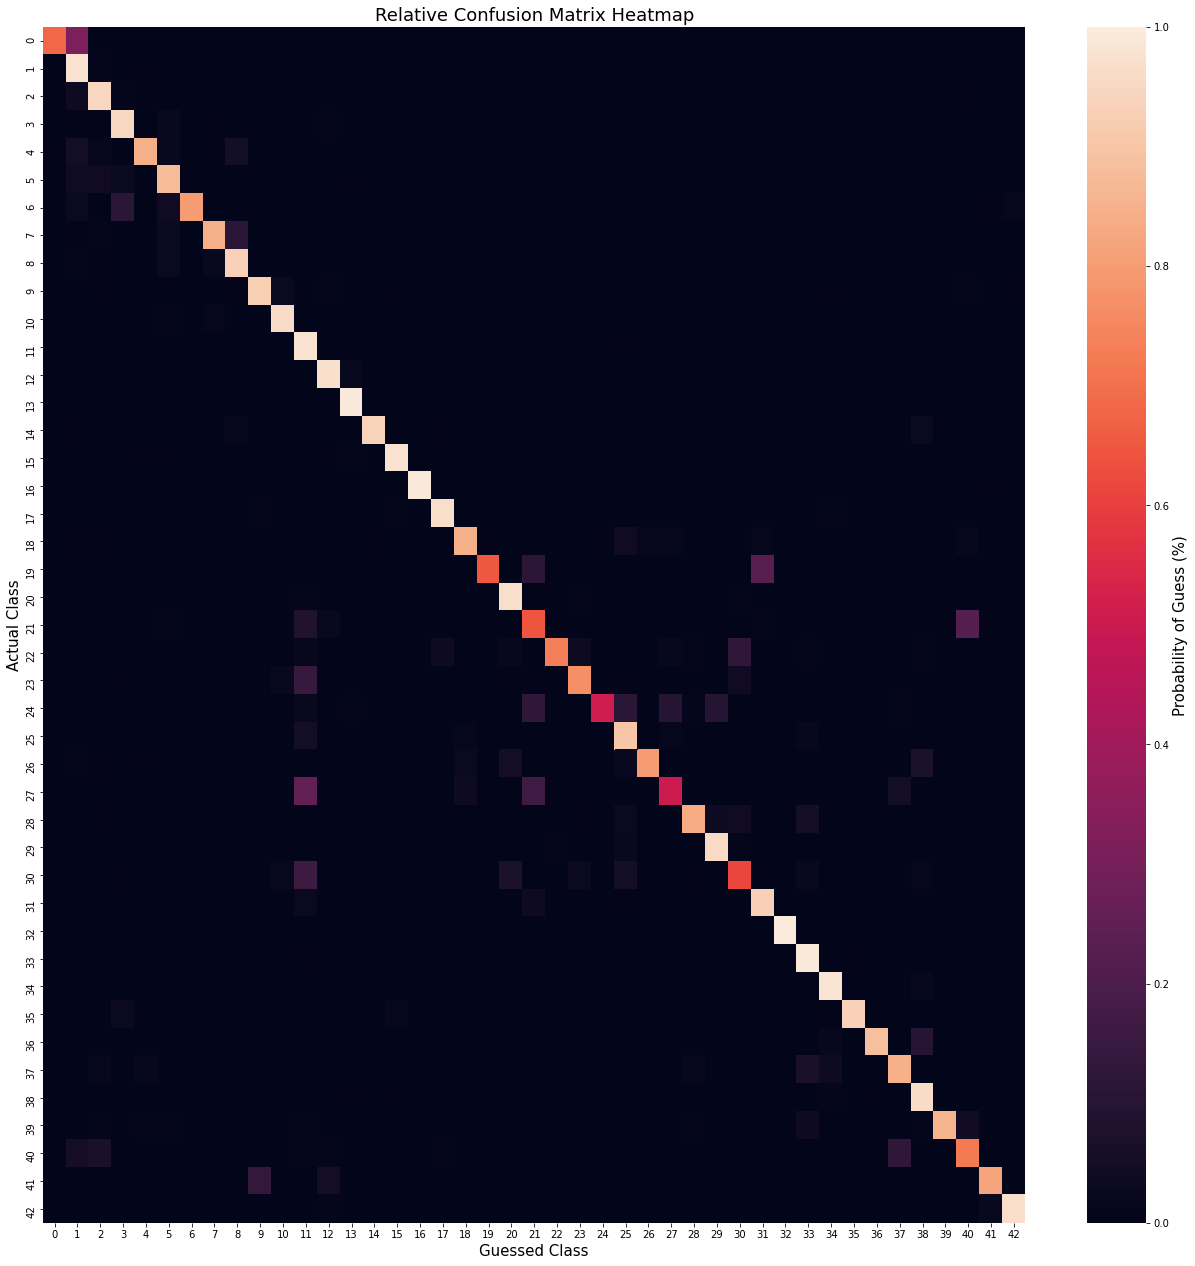

In [37]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

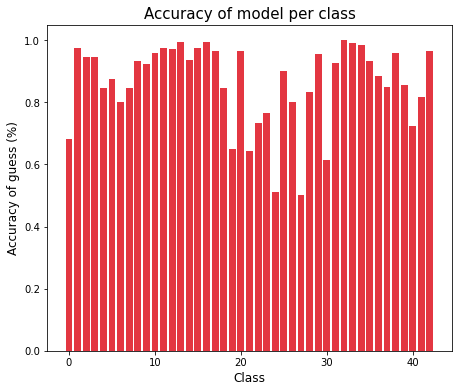

In [38]:
plot_acc_per_class(conf_mat_rel)

In [39]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


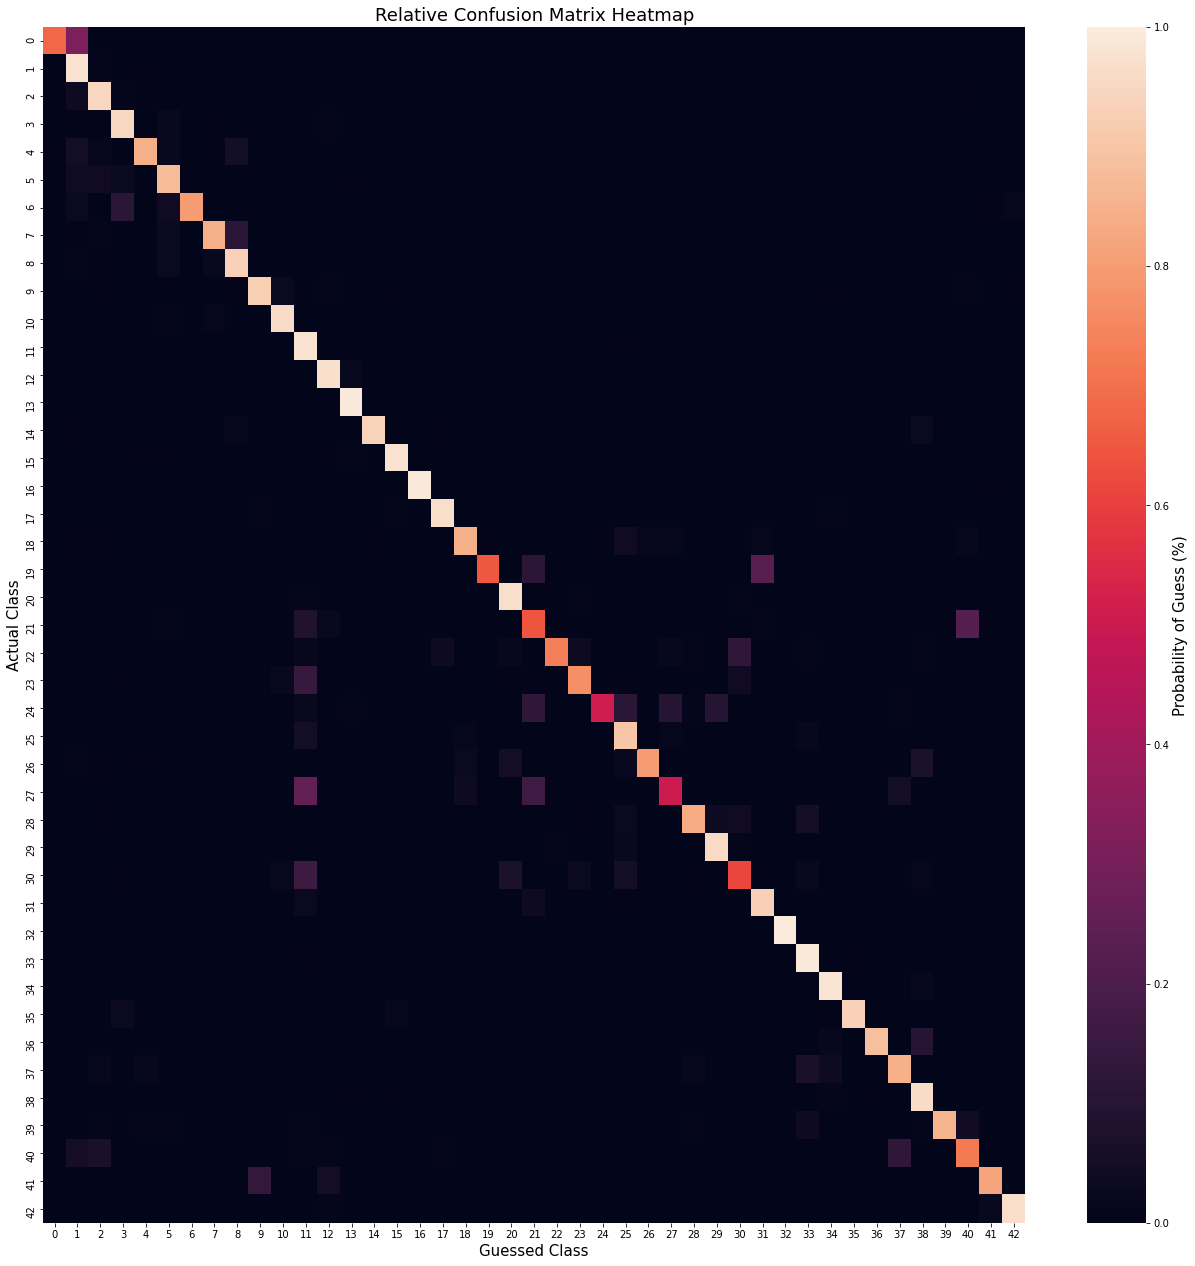

In [40]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

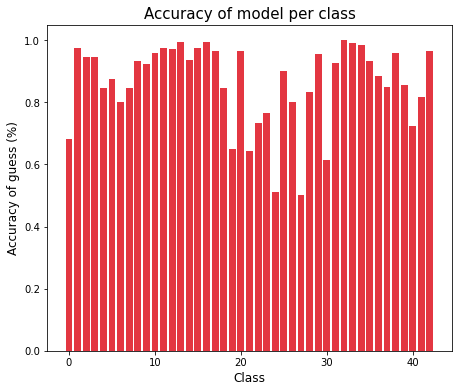

In [41]:
plot_acc_per_class(conf_mat_rel)

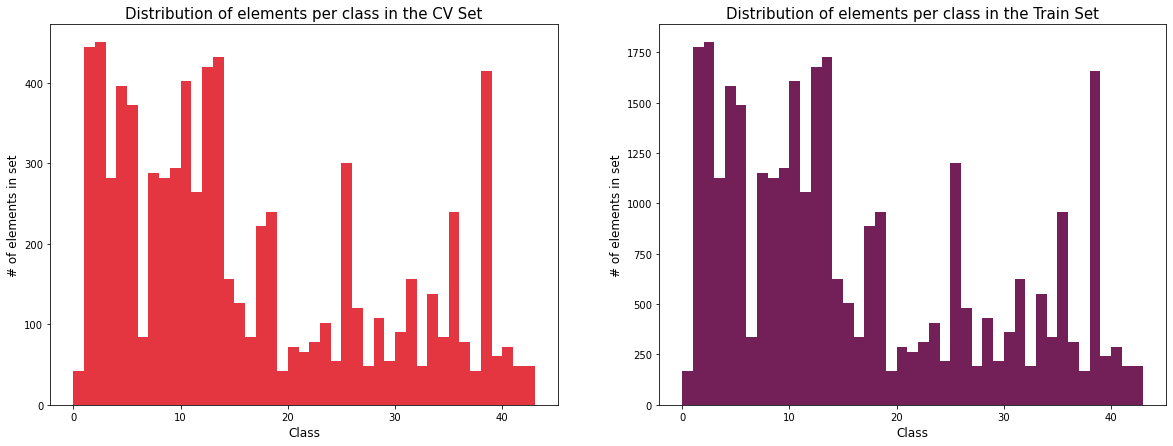

In [42]:

plot_cv_per_class(y_cv,y_train)

In [43]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


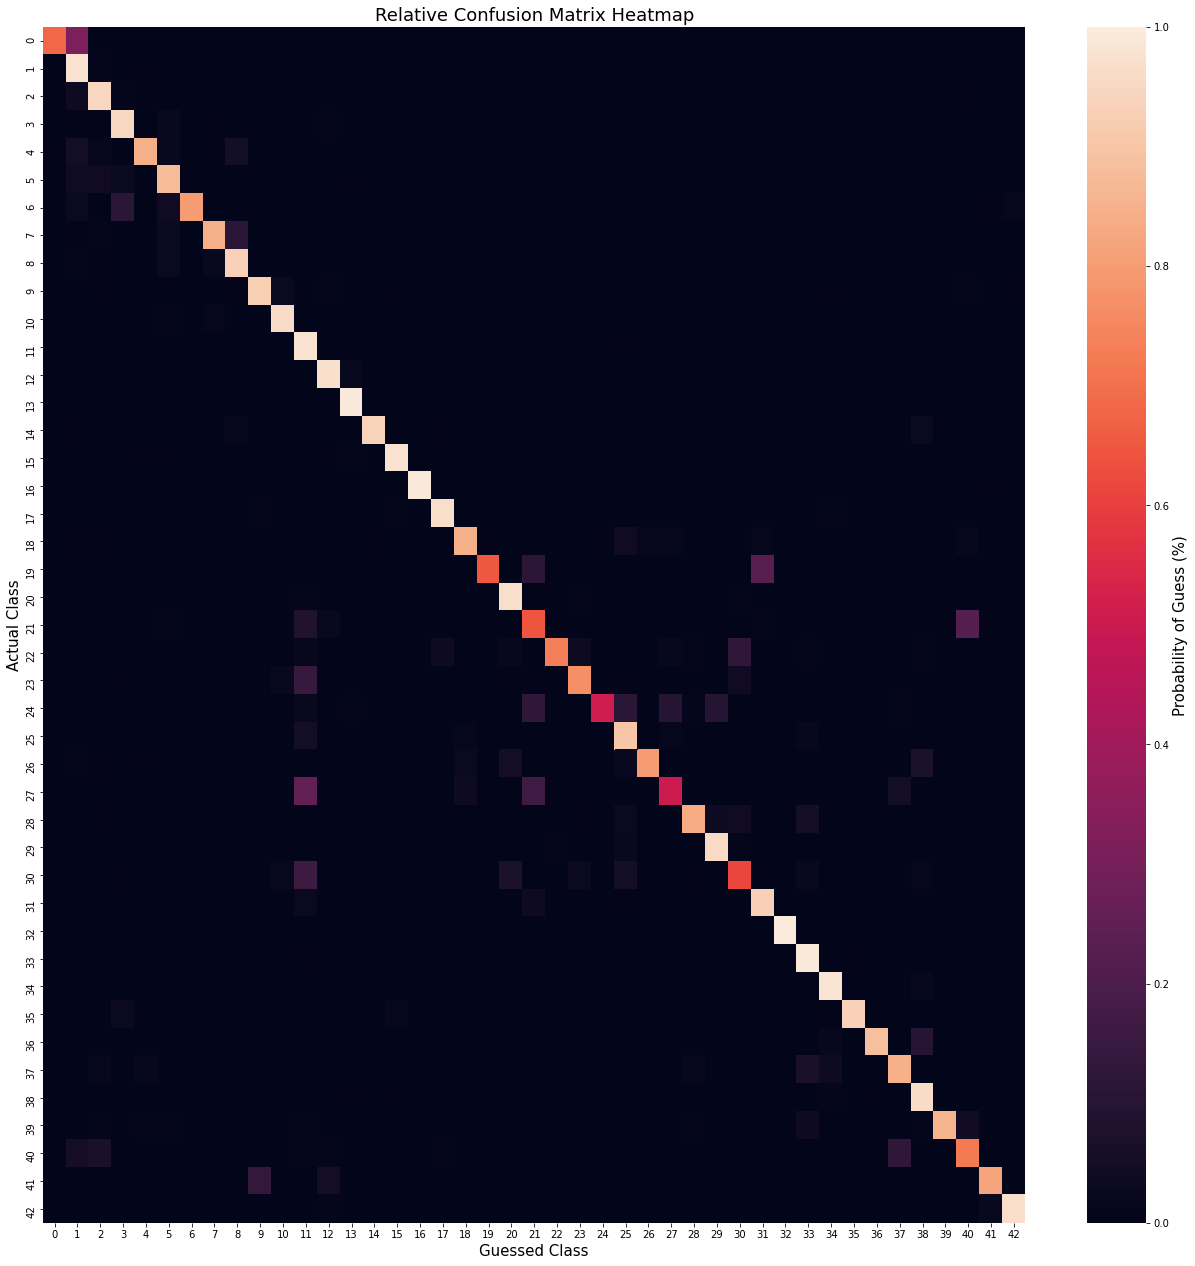

In [44]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

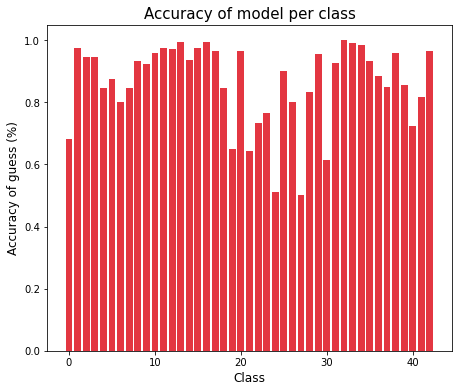

In [45]:

plot_acc_per_class(conf_mat_rel)

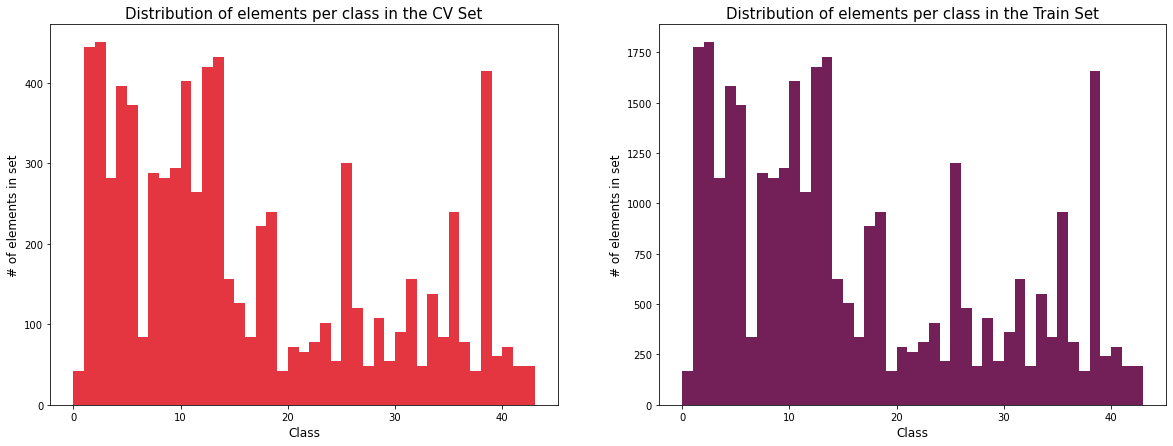

In [46]:
plot_cv_per_class(y_cv,y_train)

In [47]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.9107
Train loss: 0.03498608246445656
Train accuracy: 0.9907867908477783
CV loss: 0.13134966790676117
CV accuracy: 0.9752582311630249
Test loss: 0.7666972875595093
Test accuracy: 0.9106888175010681


[[ 41  19   0 ...   0   0   0]
 [  1 701   7 ...   0   0   0]
 [  0  24 709 ...   3   0   0]
 ...
 [  0   5   6 ...  65   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   2  87]]


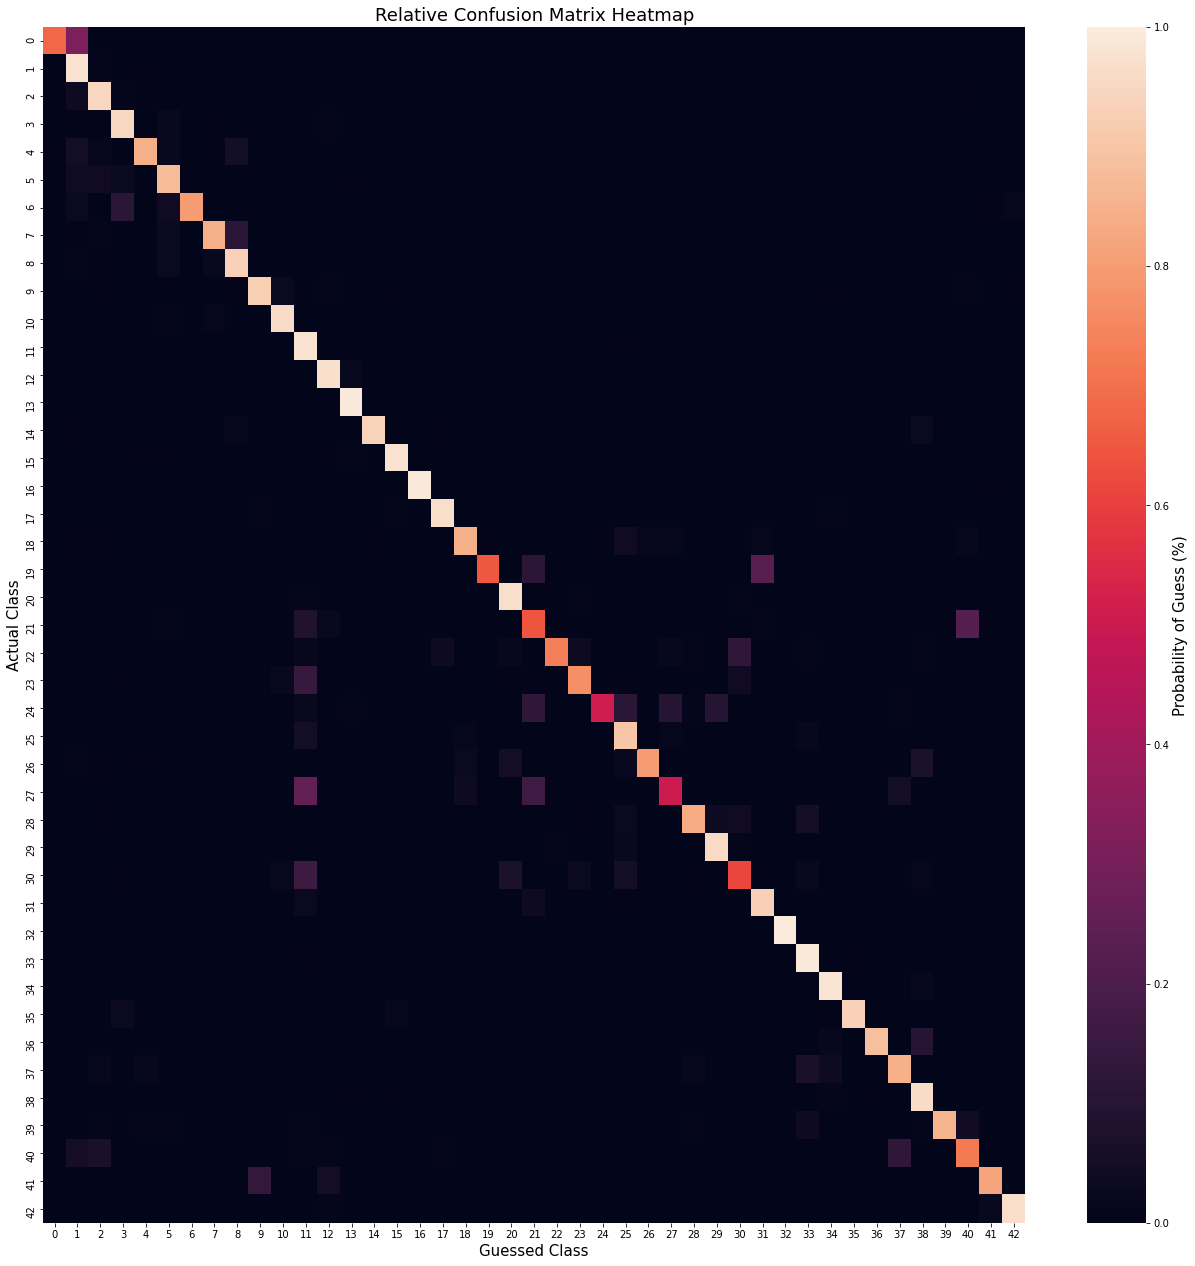

In [48]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

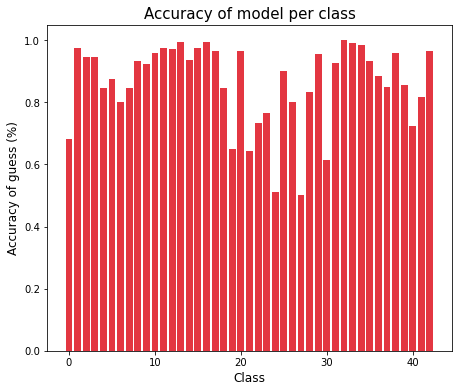

In [49]:
plot_acc_per_class(conf_mat_rel)

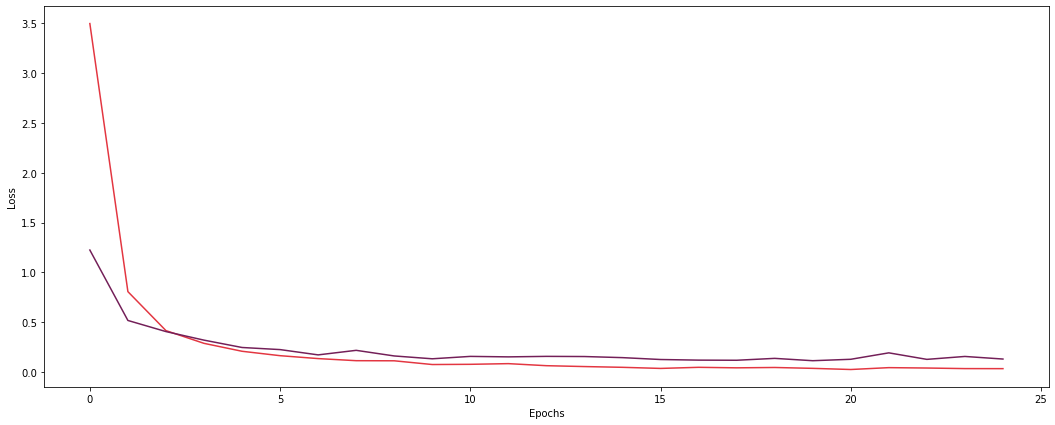

In [63]:
plt.figure(figsize = (18,7))

plt.plot(range(0,25), history.history['loss'], color="#e33641")
plt.plot(range(0,25), history.history['val_loss'], color="#731f58")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

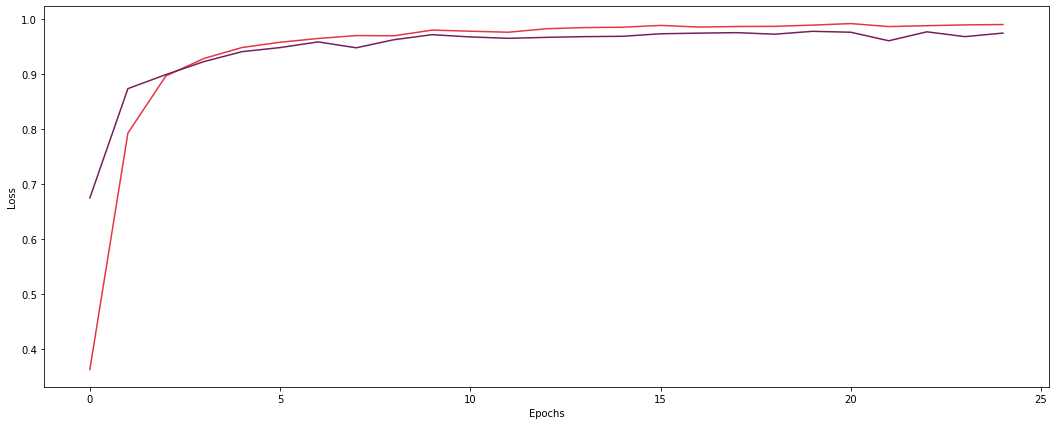

In [68]:
plt.figure(figsize = (18,7))

plt.plot(range(0,25), history.history['accuracy'], color="#e33641")
plt.plot(range(0,25), history.history['val_accuracy'], color="#731f58")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [69]:
##Using a model with only one convolutional layer
model_1CL = LeNetModel_1CL(rgb=False)

model_1CL.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history_1CL = model_1CL.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Epoch 1/25
157/157 [==============================] - 4s 23ms/step - loss: 5.0471 - accuracy: 0.3889 - val_loss: 1.1421 - val_accuracy: 0.7253
Epoch 2/25
157/157 [==============================] - 3s 22ms/step - loss: 0.7200 - accuracy: 0.8321 - val_loss: 0.5274 - val_accuracy: 0.8788
Epoch 3/25
157/157 [==============================] - 3s 22ms/step - loss: 0.3924 - accuracy: 0.9065 - val_loss: 0.4102 - val_accuracy: 0.9010
Epoch 4/25
157/157 [==============================] - 4s 22ms/step - loss: 0.2641 - accuracy: 0.9353 - val_loss: 0.3292 - val_accuracy: 0.9230
Epoch 5/25
157/157 [==============================] - 3s 22ms/step - loss: 0.1987 - accuracy: 0.9513 - val_loss: 0.3020 - val_accuracy: 0.9346
Epoch 6/25
157/157 [==============================] - 3s 22ms/step - loss: 0.1565 - accuracy: 0.9625 - val_loss: 0.2857 - val_accuracy: 0.9355
Epoch 7/25
157/157 [==============================] - 4s 23ms/step - loss: 0.1303 - accuracy: 0.9688 - val_loss: 0.2698 - val_accuracy: 0.9427

In [70]:
##Using a model with only one fully connected layer
model_1FL = LeNetModel_1FL(rgb=False)

model_1FL.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history_1FL = model_1FL.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Epoch 1/25
157/157 [==============================] - 5s 32ms/step - loss: 2.9024 - accuracy: 0.5340 - val_loss: 0.5812 - val_accuracy: 0.8592
Epoch 2/25
157/157 [==============================] - 5s 33ms/step - loss: 0.4193 - accuracy: 0.9009 - val_loss: 0.3189 - val_accuracy: 0.9254
Epoch 3/25
157/157 [==============================] - 5s 35ms/step - loss: 0.2499 - accuracy: 0.9402 - val_loss: 0.2351 - val_accuracy: 0.9427
Epoch 4/25
157/157 [==============================] - 5s 31ms/step - loss: 0.1747 - accuracy: 0.9577 - val_loss: 0.1861 - val_accuracy: 0.9579
Epoch 5/25
157/157 [==============================] - 5s 31ms/step - loss: 0.1248 - accuracy: 0.9692 - val_loss: 0.1789 - val_accuracy: 0.9577
Epoch 6/25
157/157 [==============================] - 5s 34ms/step - loss: 0.0960 - accuracy: 0.9752 - val_loss: 0.1544 - val_accuracy: 0.9645
Epoch 7/25
157/157 [==============================] - 5s 33ms/step - loss: 0.0931 - accuracy: 0.9765 - val_loss: 0.1367 - val_accuracy: 0.9679

In [71]:
model = LeNetModel(rgb=False)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))


Epoch 1/25
157/157 [==============================] - 7s 45ms/step - loss: 3.3571 - accuracy: 0.3585 - val_loss: 1.1661 - val_accuracy: 0.6907
Epoch 2/25
157/157 [==============================] - 7s 43ms/step - loss: 0.7914 - accuracy: 0.8012 - val_loss: 0.5725 - val_accuracy: 0.8623
Epoch 3/25
157/157 [==============================] - 7s 43ms/step - loss: 0.4268 - accuracy: 0.8953 - val_loss: 0.3929 - val_accuracy: 0.8987
Epoch 4/25
157/157 [==============================] - 7s 42ms/step - loss: 0.2836 - accuracy: 0.9297 - val_loss: 0.3046 - val_accuracy: 0.9278
Epoch 5/25
157/157 [==============================] - 7s 43ms/step - loss: 0.2055 - accuracy: 0.9500 - val_loss: 0.2273 - val_accuracy: 0.9453
Epoch 6/25
157/157 [==============================] - 7s 44ms/step - loss: 0.1705 - accuracy: 0.9581 - val_loss: 0.2200 - val_accuracy: 0.9448
Epoch 7/25
157/157 [==============================] - 7s 42ms/step - loss: 0.1386 - accuracy: 0.9654 - val_loss: 0.2043 - val_accuracy: 0.9531

In [72]:
y_predictions_1CL = model_1CL.predict_classes(x_test)

score = model_1CL.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history_1CL.history['loss'][-1])
print('Train accuracy:', history_1CL.history['accuracy'][-1])
print('CV loss:', history_1CL.history['val_loss'][-1])
print('CV accuracy:', history_1CL.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 2ms/step - loss: 1.4338 - accuracy: 0.8717
Train loss: 0.06840556114912033
Train accuracy: 0.984123945236206
CV loss: 0.30992406606674194
CV accuracy: 0.9543425440788269
Test loss: 1.4337962865829468
Test accuracy: 0.8717339634895325


In [73]:
y_predictions_1FL = model_1FL.predict_classes(x_test)

score = model_1FL.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history_1FL.history['loss'][-1])
print('Train accuracy:', history_1FL.history['accuracy'][-1])
print('CV loss:', history_1FL.history['val_loss'][-1])
print('CV accuracy:', history_1FL.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 1.0235 - accuracy: 0.8984
Train loss: 0.017469948157668114
Train accuracy: 0.9947717189788818
CV loss: 0.1442415714263916
CV accuracy: 0.9756408333778381
Test loss: 1.0235196352005005
Test accuracy: 0.8984164595603943


In [74]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.9162
Train loss: 0.029233630746603012
Train accuracy: 0.9920938611030579
CV loss: 0.12818416953086853
CV accuracy: 0.9806147217750549
Test loss: 0.7043708562850952
Test accuracy: 0.9162312150001526


In [75]:
conf_mat_abs_1CL, conf_mat_rel_1CL = create_confusion_matrices(y_test, y_predictions_1CL)
conf_mat_abs_1FL, conf_mat_rel_1FL = create_confusion_matrices(y_test, y_predictions_1FL)
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

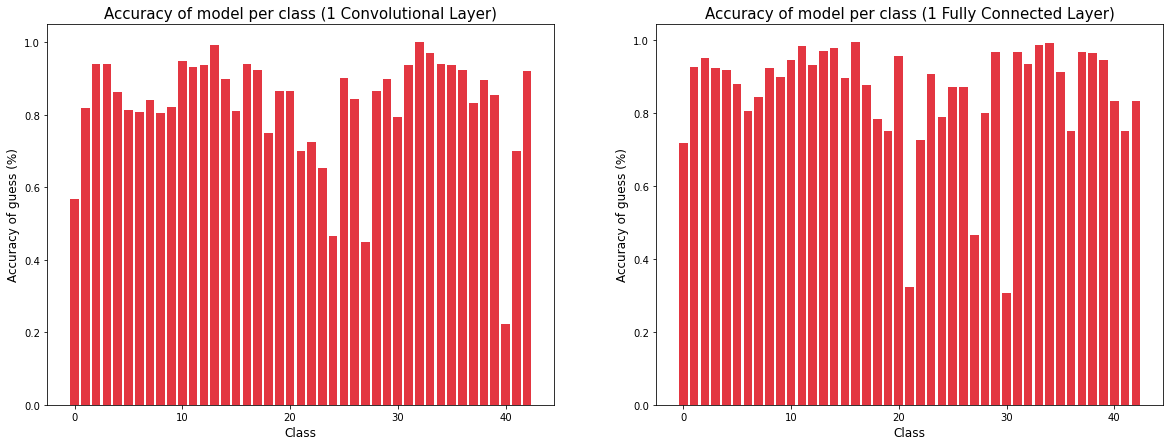

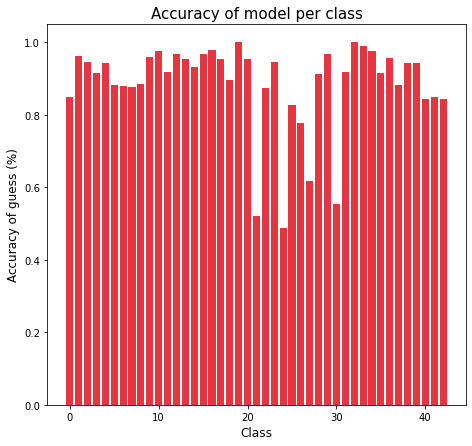

In [76]:

plt.figure(figsize = (20,7))
    
plt.subplot(1,2,1)
plt.bar(range(0,43), [conf_mat_rel_1CL[i][i] for i in range(43)], color="#e33641")
plt.xlabel('Class',fontsize=12)
plt.ylabel('Accuracy of guess (%)',fontsize=12)
plt.title('Accuracy of model per class (1 Convolutional Layer)',fontsize=15)

plt.subplot(1,2,2)
plt.bar(range(0,43), [conf_mat_rel_1FL[i][i] for i in range(43)], color="#e33641")
plt.xlabel('Class',fontsize=12)
plt.ylabel('Accuracy of guess (%)',fontsize=12)
plt.title('Accuracy of model per class (1 Fully Connected Layer)',fontsize=15)

plt.show()

plt.figure(figsize = (7.5, 7))
plt.bar(range(0,43), [conf_mat_rel[i][i] for i in range(43)], color="#e33641")
plt.xlabel('Class',fontsize=12)
plt.ylabel('Accuracy of guess (%)',fontsize=12)
plt.title('Accuracy of model per class',fontsize=15)

plt.show()

In [77]:
loss_results = []
acc_results = []
l_rates=[]
time_results = []
learning_rate = 0.00025
while learning_rate < 0.2:
    print("Learning rate at", learning_rate)
    start = time.time()
    model = LeNetModel(rgb=False)

    model.compile(loss=LOSS,
                  optimizer=OPT(learning_rate=learning_rate),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=0,
              validation_data=(x_cv, y_cv))
    
    score = model.evaluate(x_test, y_test)
    loss_results.append(score[0])
    acc_results.append(score[1])
    l_rates.append(learning_rate)
    time_results.append(time.time() - start)
    learning_rate*=2

Learning rate at 0.00025
395/395 [==============================] - 1s 4ms/step - loss: 0.9648 - accuracy: 0.8720
Learning rate at 0.0005
395/395 [==============================] - 1s 4ms/step - loss: 0.9757 - accuracy: 0.8942
Learning rate at 0.001
395/395 [==============================] - 1s 4ms/step - loss: 1.2174 - accuracy: 0.8773
Learning rate at 0.002
395/395 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.9192
Learning rate at 0.004
395/395 [==============================] - 2s 4ms/step - loss: 0.8686 - accuracy: 0.8966
Learning rate at 0.008
395/395 [==============================] - 1s 3ms/step - loss: 1.4407 - accuracy: 0.8006
Learning rate at 0.016
395/395 [==============================] - 1s 3ms/step - loss: 3.4633 - accuracy: 0.0570
Learning rate at 0.032
395/395 [==============================] - 1s 4ms/step - loss: 3.4638 - accuracy: 0.0594
Learning rate at 0.064
395/395 [==============================] - 2s 6ms/step - loss: 3.4705 - accura

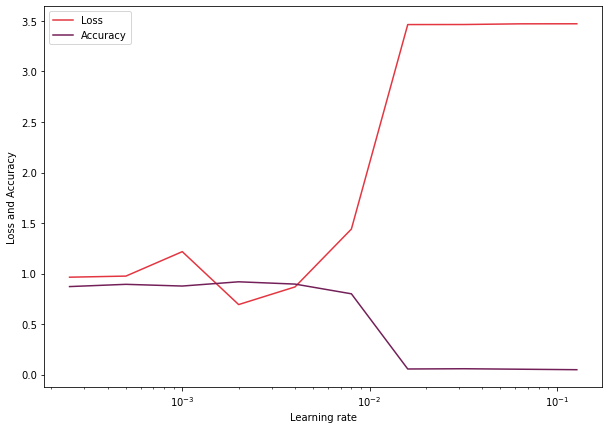

[152.4442858695984, 165.57510948181152, 165.3837206363678, 164.68869471549988, 166.4521200656891, 166.95437216758728, 164.4125895500183, 165.0482316017151, 212.50705981254578, 209.87312722206116]


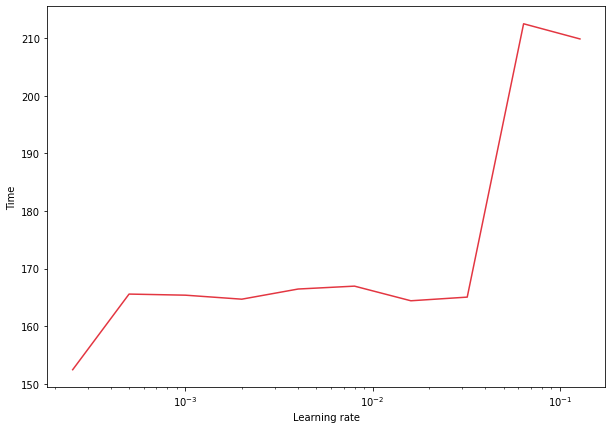

[0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]


In [78]:

plt.figure(figsize = (10,7))

plt.plot(l_rates, loss_results, color="#e33641", label='Loss')
plt.plot(l_rates, acc_results, color="#731f58", label='Accuracy')
plt.xlabel('Learning rate')
plt.ylabel('Loss and Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

plt.figure(figsize = (10,7))
print(time_results)

plt.plot(l_rates, time_results, color="#e33641")
plt.xlabel('Learning rate')
plt.ylabel('Time')
plt.xscale('log')
plt.show()

print(l_rates)

In [79]:
drop_convulutional_results = []
for i in range(0, 5):
    model = LeNetModel(rgb=False, drop_convolutional=i/10)

    model.compile(loss=LOSS,
                  optimizer=OPT(learning_rate=LEARNING_RATE),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=0,
              validation_data=(x_cv, y_cv))
    
    score = model.evaluate(x_test, y_test, verbose=1)
    drop_convulutional_results.append([score[0], score[1]])

395/395 [==============================] - 1s 3ms/step - loss: 0.5278 - accuracy: 0.9184


In [80]:
drop_conv_final = drop_convulutional_results.index(max(drop_convulutional_results, key= lambda t : t[1]))

print(drop_conv_final)

model = LeNetModel(rgb=False, drop_convolutional=drop_conv_final/10)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))

y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1
395/395 [==============================] - 1s 3ms/step - loss: 0.7565 - accuracy: 0.9127
Train loss: 0.036410342901945114
Train accuracy: 0.989447832107544
CV loss: 0.10037384927272797
CV accuracy: 0.9804871678352356
Test loss: 0.7565075755119324
Test accuracy: 0.9126682281494141


[[ 46  11   0 ...   0   0   0]
 [  0 688  15 ...   0   0   0]
 [  0   9 704 ...   3   0   0]
 ...
 [  0   3   4 ...  37   0   0]
 [  0   0   0 ...   0  44   0]
 [  0   0   0 ...   0   9  79]]


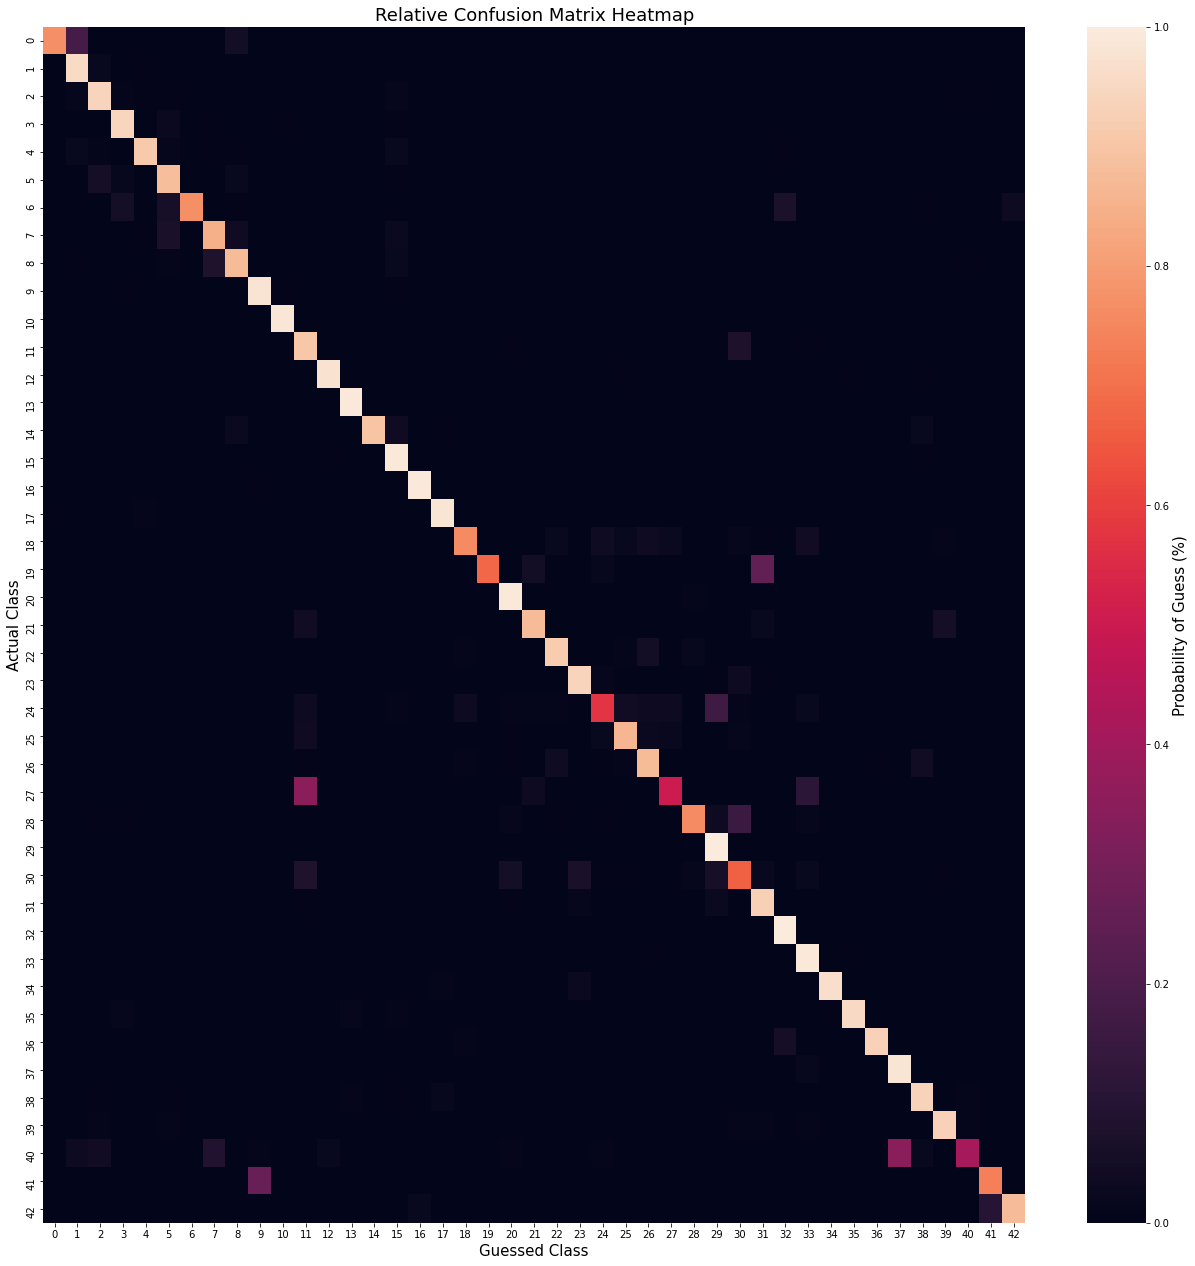

In [81]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

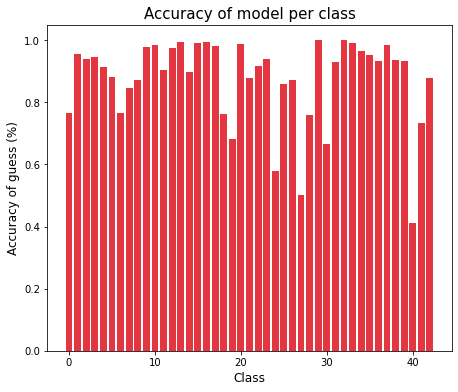

In [82]:
plot_acc_per_class(conf_mat_rel)

In [83]:
drop_final_results = []
for i in range(0, 10):
    model = LeNetModel(rgb=False, drop_fully_connected=i/10)

    model.compile(loss=LOSS,
                  optimizer=OPT(learning_rate=LEARNING_RATE),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=0,
              validation_data=(x_cv, y_cv))
    
    score = model.evaluate(x_test, y_test, verbose=1)
    drop_final_results.append([score[0], score[1]])

395/395 [==============================] - 1s 3ms/step - loss: 0.5383 - accuracy: 0.8510


In [84]:
drop_fully_final = drop_final_results.index(max(drop_final_results, key= lambda t : t[1]))

model = LeNetModel(rgb=False, drop_fully_connected=drop_fully_final/10)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))

In [85]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.3924 - accuracy: 0.9420
Train loss: 0.10457625240087509
Train accuracy: 0.9666857719421387
CV loss: 0.06423834711313248
CV accuracy: 0.9867363572120667
Test loss: 0.392378568649292
Test accuracy: 0.9420427680015564


[[ 55   2   0 ...   0   0   0]
 [  0 706   3 ...   3   0   0]
 [  0  17 724 ...   0   0   0]
 ...
 [  1   0   0 ...  73   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   8  82]]


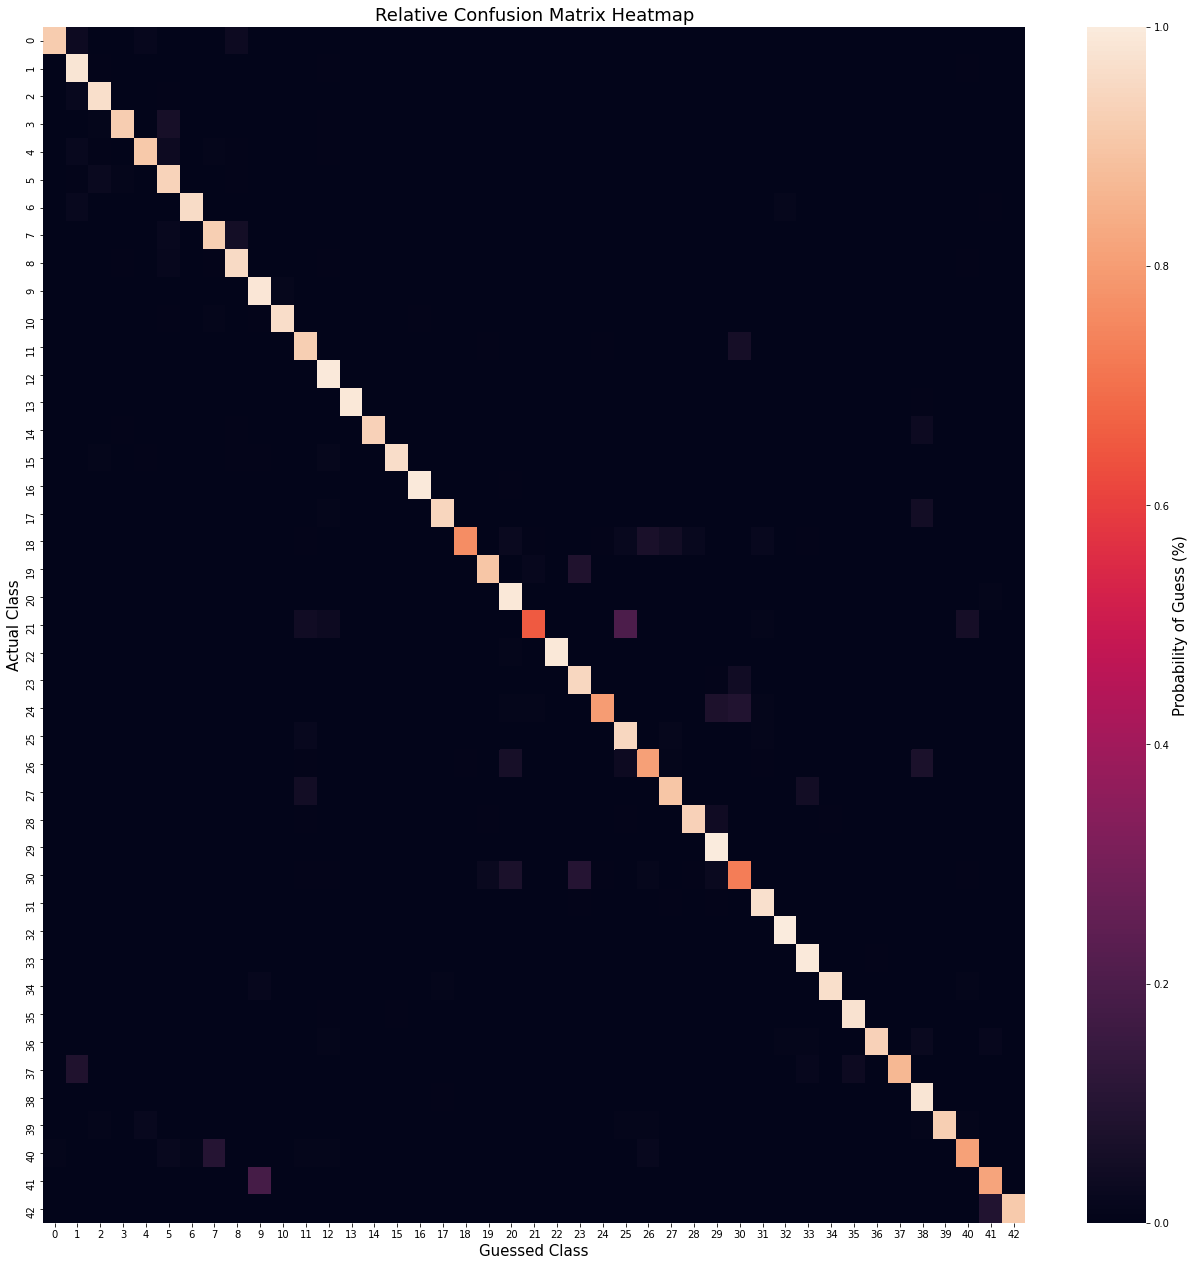

In [86]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

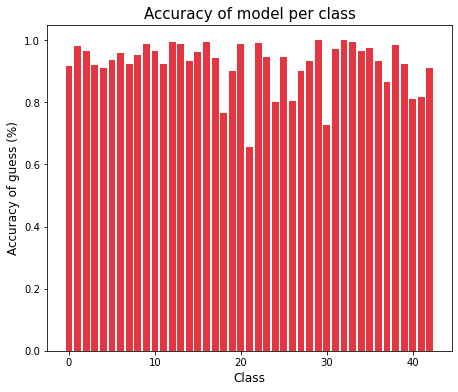

In [87]:
plot_acc_per_class(conf_mat_rel)


#### With Convulutional Dropout and Final at 0.4

In [88]:
model = LeNetModel(rgb=False, drop_fully_connected=drop_fully_final/10, drop_convolutional=drop_conv_final/10)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))

In [89]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.5149 - accuracy: 0.9272
Train loss: 0.11327825486660004
Train accuracy: 0.9656656384468079
CV loss: 0.074296735227108
CV accuracy: 0.9797219634056091
Test loss: 0.5149145126342773
Test accuracy: 0.9272367358207703


[[ 44   3   0 ...   0   0   0]
 [  0 698   1 ...   0   0   0]
 [  1  32 674 ...   2   0   0]
 ...
 [  0   5   0 ...  56   0   0]
 [  0   0   0 ...   0  43   1]
 [  0   0   0 ...   0  30  59]]


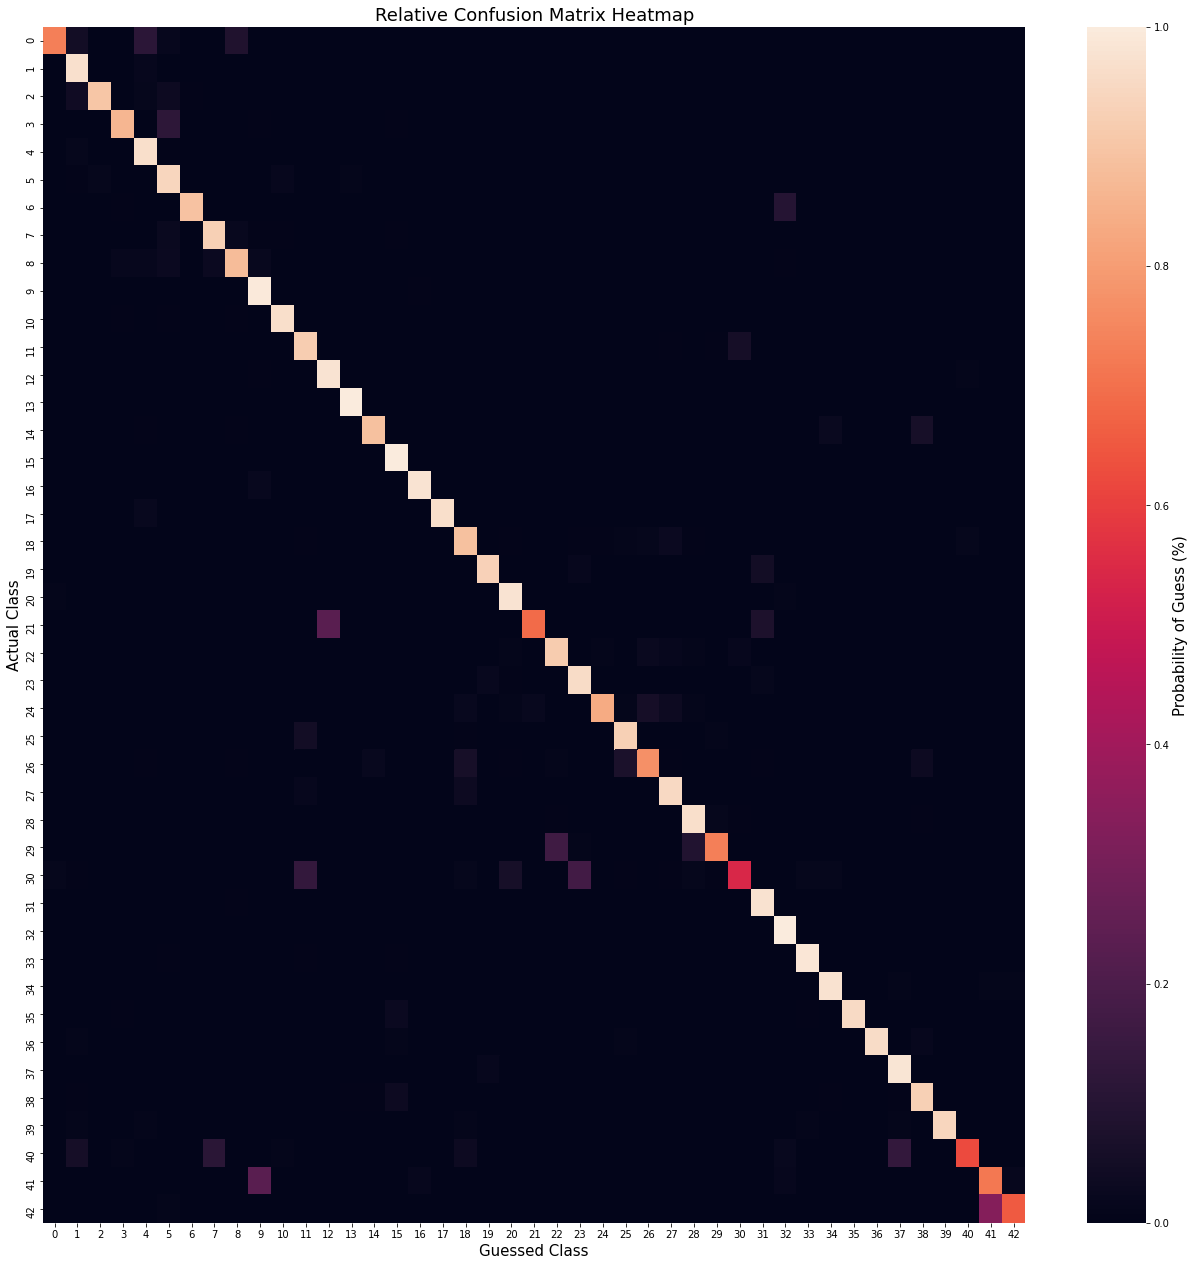

In [90]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

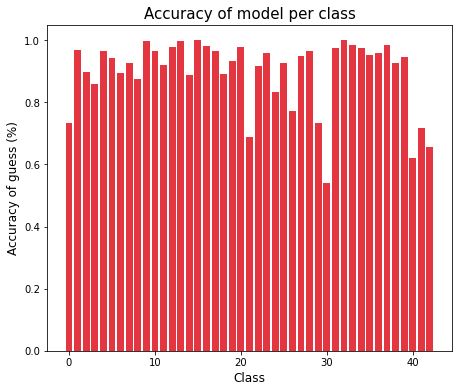

In [91]:
plot_acc_per_class(conf_mat_rel)


## Max pooling

In [92]:
model = LeNetModel(rgb=False, drop_fully_connected=drop_fully_final/10)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))

In [93]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.5384 - accuracy: 0.9273
Train loss: 0.0795380100607872
Train accuracy: 0.975739598274231
CV loss: 0.0839318260550499
CV accuracy: 0.982782781124115
Test loss: 0.538364589214325
Test accuracy: 0.927315890789032


[[ 46   3   0 ...   0   0   0]
 [  0 687  17 ...   3   0   0]
 [  0  11 728 ...   0   0   0]
 ...
 [  0  12   3 ...  67   0   0]
 [  0   0   0 ...   0  45   1]
 [  0   0   0 ...   0   0  90]]


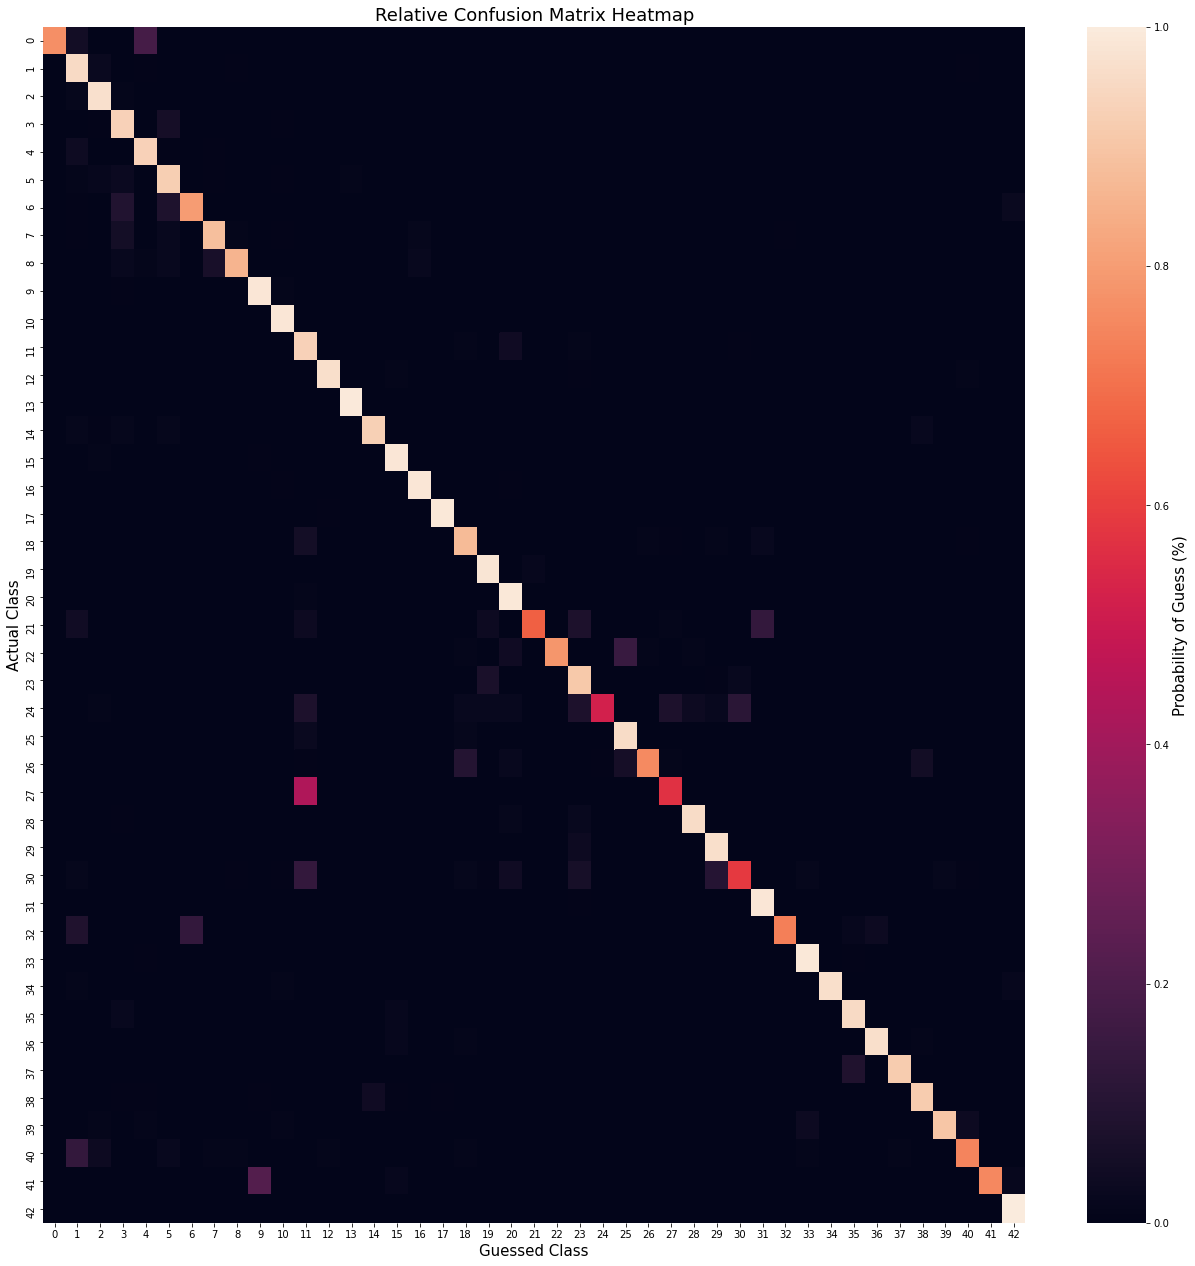

In [94]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

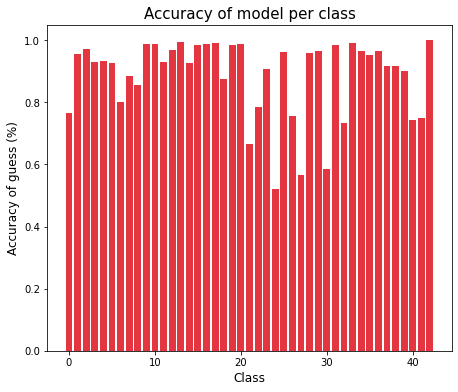

In [95]:
plot_acc_per_class(conf_mat_rel)

## Add Regularizer

In [96]:
model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))

In [97]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.7234 - accuracy: 0.9305
Train loss: 0.053673241287469864
Train accuracy: 0.9845064878463745
CV loss: 0.11460451781749725
CV accuracy: 0.9817625284194946
Test loss: 0.723445475101471
Test accuracy: 0.9304829835891724


[[ 49   2   0 ...   0   0   0]
 [  1 697   3 ...   0   0   0]
 [  0  14 689 ...   0   0   0]
 ...
 [  0  22   0 ...  48   0   1]
 [  0   0   0 ...   0  55   0]
 [  0   0   0 ...   0   0  84]]


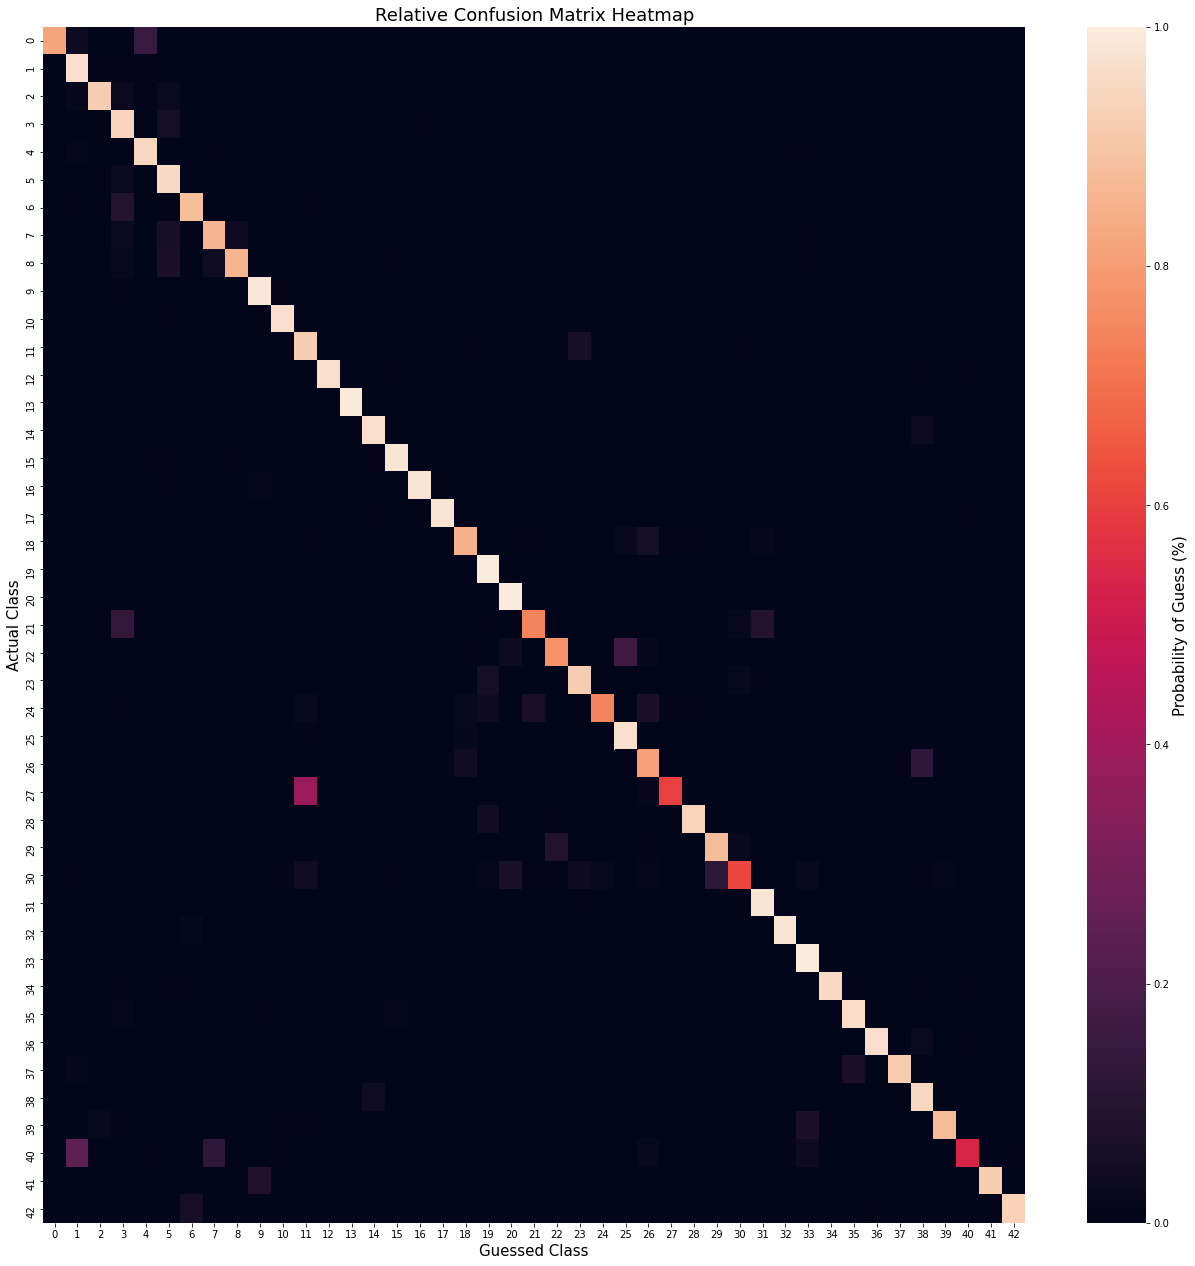

In [98]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

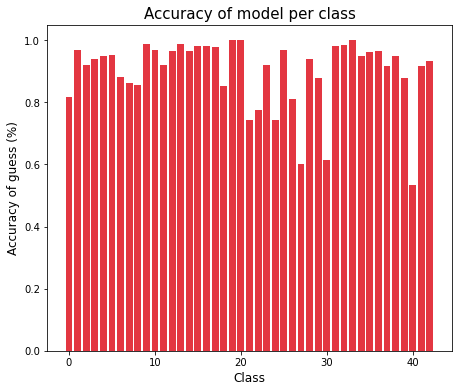

In [99]:
plot_acc_per_class(conf_mat_rel)

# Save CNN

In [100]:
model = LeNetModel(rgb=False, drop_fully_connected=0.5)

In [101]:
model.save('lastmodel.h5')

In [102]:
model = keras.models.load_model('lastmodel.h5')
model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(x_cv, y_cv))
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.4730 - accuracy: 0.9348
Train loss: 0.07483714818954468
Train accuracy: 0.9778117537498474
CV loss: 0.07063008844852448
CV accuracy: 0.9834204912185669
Test loss: 0.47301164269447327
Test accuracy: 0.9348376989364624
